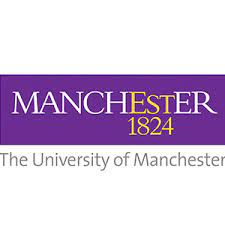<br><br>
<br>
# PHYS20762 
## The Damped Harmonic Oscillator

Aavash Subedi <br>
University of Manchester <br>
March 2022


We begin by first importing all the necessary libraries.

In [492]:
%matplotlib inline


import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sympy as smp
import sys
import math
import pandas as pd
MASTER_PARAMS = {"k": 0.6,
                "m": 2.95}

INITIAL_CONDITIONS = {"x_0":0,
                       "v_0":2}

OMEGA_SQR = np.true_divide(MASTER_PARAMS["k"], MASTER_PARAMS["m"])
print(OMEGA_SQR)
plt.rcParams.update({'font.size': 16})


0.20338983050847456


Code below is used to install the plotting style given in,  https://github.com/garrettj403/SciencePlots . 

The module will only be installed to the current Jupyter Kernel, however if the examiner does not wish to run this, its understandable. The plots will look slightly different when the code is ran. The program should run fine even if the cell is omitted.

In [495]:
#Matplotlib style pack that produces plots that adhere to scientific papers
#Could also use MNRAS style format but I prefer this repository.

# Install a pip package in the current Jupyter kernel
!{sys.executable} -m pip install SciencePlots


In [496]:
try:
    #IEEE style used as the journal requires clear visibility without use of colour.
    plt.style.use(["science", "no-latex", "ieee"])
    plt.rcParams["figure.figsize"] = (8, 5)

except:
    print("Dependency not found, using default.")
    plt.style.use(["default"])

### Introduction to Project

The general aim of the project is to investigate a Damped Harmonic Oscilaltor using numerical methods.  Four diffrent numerical integration methods are tested and their accuracies are compared against analytical solutions.  The motivation behind this project is to demonstrate that O.D.E's can be solved numerically and extrapolate this methodology to solve more complex solutions that do not (yet) have anaytical solutions.  Euler, improved Euler, Verlet and Euler-Cromer methods are considered. 

### Theory

A spring-mass system follows a second order diffrential equation given by, $$ma +kx + bv = F(t),   \;\;\;\;$$

where, $m$ is the masss, $a$, $v$ and $x$ are defined as the acceleration, velocity and displacmenet of the masss. $\;$ An external time dependent force $F(t)$ acts on the system of spring constant $k$. $\;$ The damping forces contribute a damping constant $b$ to the equation. The equation can be further simplified to, 

$$\ddot{x} + \gamma\dot{x} + {\omega_0}^2 x = F(t),\;\;(1)$$

where $\gamma = \frac{b}{m}$ and ${\omega_0}^2$, defined as the natural angular frequency is equal to $\frac{k}{m}$.


For a system with no driving force $F(t)$, an analytical solution can be obtained readily. Subbing the exponential anasatz, $$x(t) = e^{\lambda t} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; (2)$$ into the above equation leads to a readily solvable ODE.  $\lambda$ are the roots to the quadratic auxillary equation.  The three resulting cases for a damped oscillator are, 
$$b^2 - 4mk > 0,\;\;\;\;\;\;\;\;\;\;\;\; (3)$$
$$b^2 - 4mk = 0,\;\;\;\;\;\;\;\;\;\;\;\; (4)$$
$$b^2 - 4mk < 0.\;\;\;\;\;\;\;\;\;\;\;\; (5)$$

The three cases given by equation 3, 4 and 5 are related to heavy-damping, critically damped and underdamped oscillators.

An overdamped system is which the damping factor will cause it to return to equillibrium without oscillating. $\;$ Similarly, a critically damped system will also cease to oscillate, however the amplitude of the system returns as quickly as possible to the equillibrium position.$\;$  An underdamped system does oscillate but the overall amplitude converges to zero, similar to the other cases. $\;$ An undamped system will oscillate forever without dissipating any energy. 

For such a system the general solution is given by the equation below.

In [5]:
from sympy import Function
from sympy.abc import t
from sympy.physics.units.quantities import Quantity

m = Quantity("m")
k  = Quantity("k")
b = Quantity("b")

#Displacment from center
x = smp.symbols("x", cls=smp.Function)

function = smp.dsolve(m*x(t).diff(t, t)
 - b*x(t).diff(t)+ k*x(t), x(t))

display(function)

Eq(x(t), C1*exp(t*(b - sqrt(b**2 - 4*k*m))/(2*m)) + C2*exp(t*(b + sqrt(b**2 - 4*k*m))/(2*m)))

An analytical solution is found by substituting for the relavent coefficents and setting some initial parameters. For the diffrent cases, analytical solutions have the form:
- Light damping (${\omega_0}^2 > \frac{\gamma^2}{4}$):
$$x(t) = Ae^{-\frac{\gamma}{2}t}cos(\omega t + \phi),$$

where $\omega = \sqrt{{\omega_0}^2 - \frac{\gamma^2}{4}}$ and $\phi$ is the phase shift.

- Heavy damping (${\omega_0}^2 < \frac{\gamma^2}{4}$):
$$x(t) = e^{-\frac{\gamma}{2}t}\left(Ae^{\alpha t} + Be^{-\alpha t}\right),$$

where $\alpha = \sqrt{\frac{\gamma^2}{4} - {\omega_0}^2}.$

- Critcal damping (${\omega_0}^2 = \frac{\gamma^2}{4}$):
$$x(t) = Ae^{\alpha t} + Be^{-\alpha t}.$$



In [433]:
def analytical_solution(time: np.ndarray, angular_freq:float = OMEGA_SQR,
                        damping:float = 0, mass: float = MASTER_PARAMS["m"])  -> (np.ndarray, np.ndarray):
    """
    Returns the next iteration of position and velocity. The function calculates, which 
    of the three cases of damping the system belongs to and solves for the appropriate
    equation. 

    
    -----------
    time: array = Array of time data that the analytical solution is required for.
    
    Returns:
    position: array = Array of positions at the corresponding time.
    velocity: array = Array of velocities at the corresponding time.
    """
    gamma = damping/mass
    conditional = np.square(gamma) / 4 - angular_freq
    #Critical damping, we set a small range between 10e-6 to 10e-6 which is the
    #to allow for a mode to be considered critical damping, otherwise it wont be.
    if -10e-6<conditional<10e-6:
        alpha = math.sqrt(conditional)
        constant_one, constant_two = 0.5 * alpha, -0.5 * alpha
        
        position = constant_one * np.power(math.e, alpha * time) + (
                   constant_two * np.power(math.e, -alpha * time))
        
        velocity = alpha * (contant_one * np.power(math.e, (alpha * time))) -(
                   alpha * (contant_two * np.power(math.e, (alpha * time))))
    #Heavy damping case
    elif conditional >0: 
        alpha = np.sqrt(conditional)
        constant_one, constant_two = 1/(2 * alpha), -1 / (2 * alpha)
        
        #Substituting constants into the analytical solution.
        position = np.power(math.e, (-0.5 * gamma * time)) * (constant_one * np.power(
                   math.e, (alpha * time)) + constant_two * np.power(
                   math.e, (-alpha * time)))
        
        velocity = alpha * np.power(math.e, (-0.5 * gamma * time))*(
                   constant_one * np.power(math.e, (
                   alpha * time))- constant_two * np.power(
                   math.e, (-alpha * time))) -0.5 * gamma * np.power(
                   math.e, (- 0.5 * gamma * time)) * (
                   constant_one * np.power(math.e, (alpha * time)) +(
                   constant_two * np.power(math.e, (-alpha * time))))
        
        return position, velocity                           
            
    #Light damping
    else: 
        frequency = math.sqrt(angular_freq - gamma**2 / 4)
        constant_one = -1 / frequency
        
        position = constant_one * np.power(math.e, (-0.5 * gamma*time)) *(
        np.cos( frequency * time + 0.5 * math.pi))
        
        velocity = -gamma/2 * constant_one * np.power(math.e,
                                                      (-0.5 * gamma * time)) *(
        np.cos(frequency * time + 0.5*math.pi) - frequency* constant_one*(
        np.power(math.e, (-0.5 * gamma * time))* np.sin(
        frequency * time + 0.5*math.pi)))
        
    


    return position, velocity

    
def energy_calculator(displacement:np.ndarray, velocity:np.ndarray,
                     spring_constant:float = MASTER_PARAMS["k"],
                     mass:float = MASTER_PARAMS["m"]) -> np.ndarray:
    """
    Calculates the total energy given the velocity and displacment of the mass.
    Returns the sum of the kinetic and potential energy at a point in the form
    of a numpy array.
    """
    energy = 0.5*spring_constant*np.square(
             displacement) +  0.5*mass*np.square(velocity)
    
    return energy
    
                       

In [22]:
TODO = [
"Add some sort of plot for each type of damping. 3 plots side by side.",
"Add section on forced oscillations"
]

### Numerical Integration

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


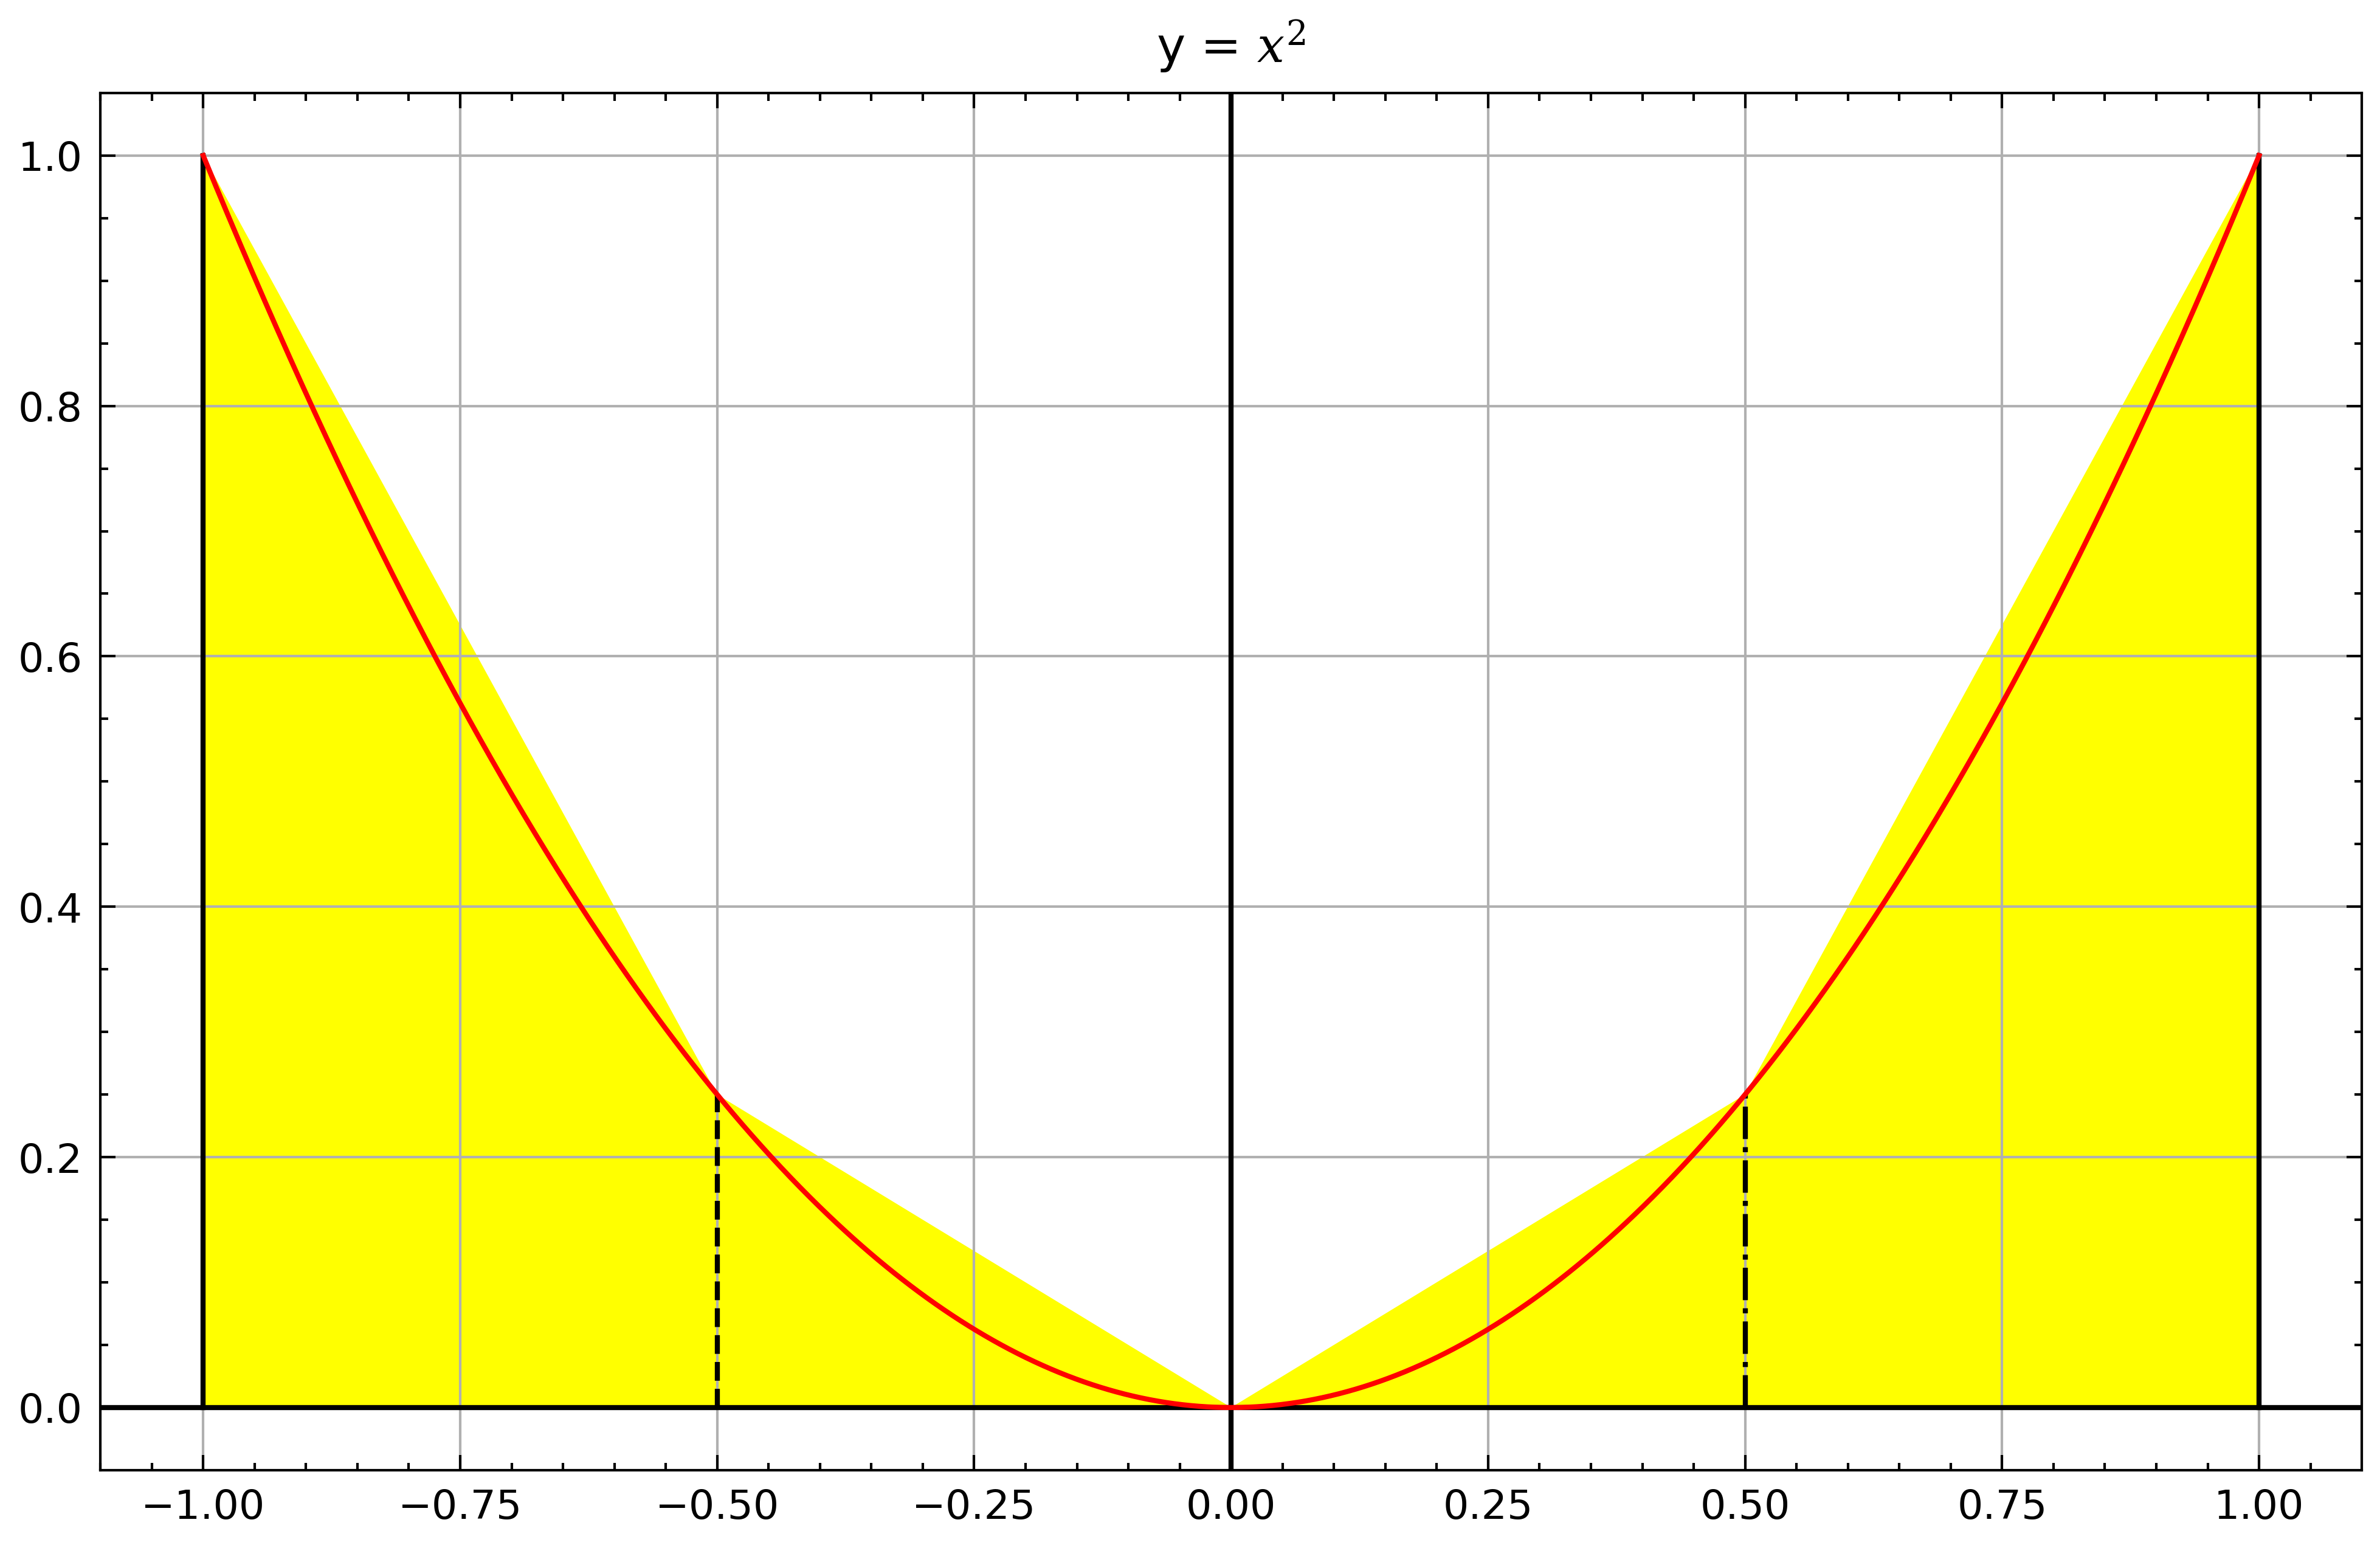

In [7]:
def polynomial_2(x:float) -> float:
    return x**2

x = np.linspace(-1, 1, 1500)
xstep = np.linspace(-1, 1, 5)
plt.grid()
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.fill_between(xstep, 0, polynomial_2(xstep), facecolor='yellow')
plt.title(f"y = $x^2$")
for xval in xstep:
    plt.plot((xval, xval), (0, polynomial_2(xval)), color='black')
plt.plot(x, polynomial_2(x),'r-');


Not all functions have simple antiderviates therefore solving these functions analytically can be quite challenging. For example, solving the Biot-Savart Law analytical for a given point (a, b, c) takes approximately 20 minutes using SymPy symbolic intergration. In these cases, numerical intergration is required for solve these problems to a reasonable degree of accuracy. If the antiderivative is interpreated as computing the area enclosed by the function then we can split the problem into the summation of small trapeziums as can be seen in the figure above. This is an example of numerical intergration and is known as Trapezium rule.  Several numerical intergrational methods are investigated within this notebook.

Runge-Kutta methods are a family of iterative methods used to integrate ordinary diffrential equations (ODE's).  The class of methods use the information of the "slope" or tangent at more than one point to extrapolate the solution for future time steps.
$\;$One problem that presists through numerical intergration methods such as the Runge-Kutta are that as they are iterative, it is very difficult to parralellise the code.  $\;$Such methods do exist but are not considered within this project [1].

Source: T. Young, “I. the bakerian lecture. experiments and calculations relative to physical optics,”
Philosophical Transactions of the Royal Society of London, pp. 1 – 16.



#### 1. Euler
The Euler method is a first order [1] explicit method.  It is the simplest method to obtain a numerical solution and it is generally known to be unstable hence with a local error (error per step) being proportional to the square of the step, $O(h^2)$ with a global error of $O(h)$ [2]. $\;$ The method is used to  calculate the state $X(t_{i+1})$, given the state $X(t_{i})$. 

<img src="https://pythonnumericalmethods.berkeley.edu/_images/22.03.01-Euler-method-illustration.png" width=400 height=400 class="center">

Image obtained from source [2].

The Euler method can be derived by taking the Taylor expansion of the function $X$ around $t_0$,
$$X(t_0+h) = X(t_0) + hX'(t_0) + O(h^2). \;\;\;\; $$

By iterating over a number of time steps, the final state at a given time $t$ can be obtained.

\
\
[1] Atkinson, Kendall A. (1989). An Introduction to Numerical Analysis (2nd ed.). New York: John Wiley & Sons. ISBN 978-0-471-50023-0.
\
[2] https://pythonnumericalmethods.berkeley.edu/notebooks/chapter22.03-The-Euler-Method.html accessed on: 07/04/2022

In [8]:
def forward_euler(position:float, velocity:float, timestep:float, 
    angular_freq:float = OMEGA_SQR, damping:float = 0, 
    mass: float = MASTER_PARAMS["m"]) -> (float, float):
    
    """
    Iterator for calculating the next position and velocity using the Euler Method.
    
    Returns a tuple of floats containing the position and velocity of the next timestep.
    """
    
    gamma = damping/mass
    acceleartion = -angular_freq * position - gamma*velocity

    next_position = position + timestep*velocity
    next_velocity = velocity + timestep*acceleartion

    return next_position, next_velocity

    

There are fundamental issues that arise due to Euler's method.  The iterative timesteps are given by, 
$$x_{i+1} = x_i +hv_i,$$
$$ v_{i+1} = v_i + ha_i,$$
$$a_i = -\frac{k}{m}x_i -\frac{b}{m}v_i.$$

For an undamped system, the expression for total energy is given by,
$$E_{i+1} = E_k + E_p = \frac{1}{2}kx^2_i + \frac{1}{2}mv^2_i + \frac{h^2k^2x^2_i}{2m} +\frac{h^2kv^2_i}{2}.$$
Upon simplification, this leads to, 
$$E_{i+1} = E_i(1+\frac{k}{m}h^2).$$

Hence, Euler's method predicts a steady increase in the energy of the system, which is un-physical as we would expect an undamped system to retain the same total energy.

From the local truncation error of the method, $O(h^2)$, it is evident to see that a smaller value of the step size would minimise the error introduced by the approximation, but if $h$ is too small then there will be cancellation errors due to the finite precision used in represnting the numbers invovled [1]. $\;$ There is a lower limit on what value $h$ can be chosen to be, if a value lower than the machine epsilon is taken, then we will obtain, $x_{i+1} = x_{i-1}$, which would result in a straight line.

The choice of step size is explored further in the notebook and is a feature that is present in all of the numerical methods discussed below.

Source:
[1] $\;$ Hill, C. (2016). General scientific programming. In Learning Scientific Programming with Python (pp. 402-423). Cambridge: Cambridge University Press. doi:10.1017/CBO9781139871754.009



#### 2. Improved Euler

The simplest method to improve the base Euler Method is to include an extram term in the Taylor expansion of the derivative.  For a function, $X$ the improved Euler formulation is,
$$X(t_0+h) = X(t_0) + hX'(t_0) + \frac{1}{2}h^2X''(t_0) + O(h^3). \;\;\;\; $$

Hence, the local error is now proportional to $h^3$. The modified of iterative equations are given by,
$$x_{i+1} = 2x_i - x_{i-1} + h^2a_i,$$
$$v_i = \frac{x_{i+1} - x_{i-1}}{2h},$$
$$a_i = -\gamma x_i - {\omega_0}^2v_i.$$

The energy associated with each iterative timestep for the improved Euler method is given by,

$$E_{i + 1} = \frac{1}{2}k\left[x_i\left(1-\frac{h^2k}{2m}\right) + hv_i\left(1-\frac{hb}{2m}\right)\right]^2 + \frac{1}{2}m\left[v_i\left(1-\frac{hb}{m}\right) - x_i\frac{hk}{m}\right]^2.$$

It is evident from the previous equation that the improved Euler method also does not conserve energy.


#Delete this 
The Euler method generates the tangent to the line based on the initial point, however there is no way of saying that the next point will lie within the line itself.  This could lead to the iterative value being over or under estimated.  The Improved Euler method addresses these problems and hence reduces the error surrounding Eulter method.  

In [9]:
def improved_euler(position:float, velocity:float, timestep:float, 
    angular_freq:float = OMEGA_SQR, damping:float = 0, 
    mass:float = MASTER_PARAMS["m"]) -> (float, float):
    
    """
    Iterator for calculating the next position and velocity using the
    Improved Euler Method.
    
    Returns a tuple of floats containing the position and velocity
    of the next timestep.
    """
    
    gamma = damping/mass
    acceleration = - angular_freq * position - gamma*velocity
    
    next_position = position + timestep*velocity + (timestep**2/2)*acceleration
    next_velocity = velocity + timestep*acceleration
    
    return next_position, next_velocity



#### 3. Verlet's Method

Verlet's is a symplectic second order method that is outside the family of Runge-Kutta methods.  It holds energy fairly constant compared to the other methods outlined above. The formulation arises from a centered derivative where,
$$ \frac{dX}{dt} = \lim_{h\to 0}\frac{X(t+h) - X(t - h))}{2h}$$.

Following this, two Taylor expansions are taken for $x(t+h)$ and $x(t-h)$. 
Following this procedure and taking derivatives of the above equation, iterative equations are obtained of the form,

$$x_{i+1} = 2x_i - x_{i-1} + h^2a_i + O(h^4),$$
$$v_i = \frac{x_{i+1} - x_{i-1}}{2h} + O(h^2),$$
$$a_i = -\gamma x_i - {\omega_0}^2v_i + O(h^2).$$

As we only want $x$, we can combine the equations to give, 
$$x_{i+1} = 2\frac{2m - kh^2}{2m + bh}x_i + \frac{bh - 2m}{2m + bh}x_{i-1}$$

The local truncation error within verlet is $O(h^4)$ for the position and $O(h^2)$ for the velocity therefore the error associated with each data point reduces much quicker compared to the other values with increasing $h$. In contrast to Euler methods, the global error of Verlet methods are of order two.   However, one downside of the Verlet method is that is not self-starting, so another method has to be used once to start the algorithm. 

In [10]:
def verlet(position:float, previous_position:float, timestep:float, 
    angular_freq:float = OMEGA_SQR, damping:float = 0, 
    mass: float = MASTER_PARAMS["m"],
    spring_constant:float = MASTER_PARAMS["k"]) -> (float, float):
    
    """
    Iterator for calculating the next position and current velocity using
    the Verlet method. Requires the position at the previous timestep
    and the current position to calculate the next position. Velocity
    is calculating the gradient of the displacement time graph between
    the current and next position.
    
    Returns a tuple of floats containing the position and velocity
    of the next timestep.
    """
    
    gamma = damping/mass
    next_position = 2 * ((2*mass - spring_constant * timestep**2)/(
        2*mass + damping * timestep))* position + (
        (damping * timestep - 2*mass) / (2*mass + damping * timestep)
    ) * previous_position
    
    next_velocity = (next_position - previous_position)/(2*timestep)
    
    
    return next_position, next_velocity



#### 4. Euler-Cromer

Returning back to a Runge-Kutta method, the Euler-Cromer method is a symplectic version version of the Euler method. It is also self starting and conserves energy through oscillations.  It utilises "leapfrogging", which leads to the velocity being computed at the same iteration or timestep as the dispaclement [1][2].  The slight modification in the Euler method yeilds, 
$$x_{i + 1} = x_i + hv_{i+1},$$
$$v_{i + 1} = v_i + ha_i.$$
<br>
The equation for the energy also has to be modified, $$E_{i+1} = E_i -\frac{h^2}{2}\left(\frac{k^2{x_i}^2}{m} - k{v_i}^2\right) - h^3\frac{k^2x_iv_i}{m} + h^4\frac{k^3{x_i}^2}{2m^2}.$$

The last three terms in the right hand side of the equation, average to 0 over one full oscillation, hence the energy is conserved.

[1] $\;$ A. Cromer, Stable solutions using the Euler Approximation, American Journal of Physics, 49, 455 (1981) <br>

[2] $\;$ P.Young, The leapfrog method and other "symplectic" algorithms for intergrating Newton's laws of motion, University of California, Santa Cruz (2013)

In [289]:
def euler_cromer(position:float, velocity:float, timestep:float, 
    angular_freq:float = OMEGA_SQR, damping:float = 0, 
    mass: float = MASTER_PARAMS["m"]) -> (float, float):
    
    """
    Iterator for calculating the next position and velocity using the
    Euler-Cromer method.
    
    Returns a tuple of floats containing the position and velocity
    of the next timestep.
    """
    
    gamma = damping/mass
    acceleration = -angular_freq*position - gamma*velocity
    
    next_position = position + timestep*(velocity + timestep*acceleration)
    next_velocity = velocity + timestep * acceleration
    
    return next_position, next_velocity



# Experiment Approach

Initally, we investigate the system when there is no external force acting. I.e. we set $F(t) = 0$. The properties of each numerical method is investigated.

Lets begin by plottinng the output of the analytical solution, solved using 
sympy ( this is used to demonstrate the variety in the methods to use, after this the user-defined function is used. Here, the damping factor used is zero.

Analytical solution:


Eq(x(t), -1.10867789130417*I*exp(0.450987616801697*I*t) + 1.10867789130417*I*exp(-0.450987616801697*I*t))

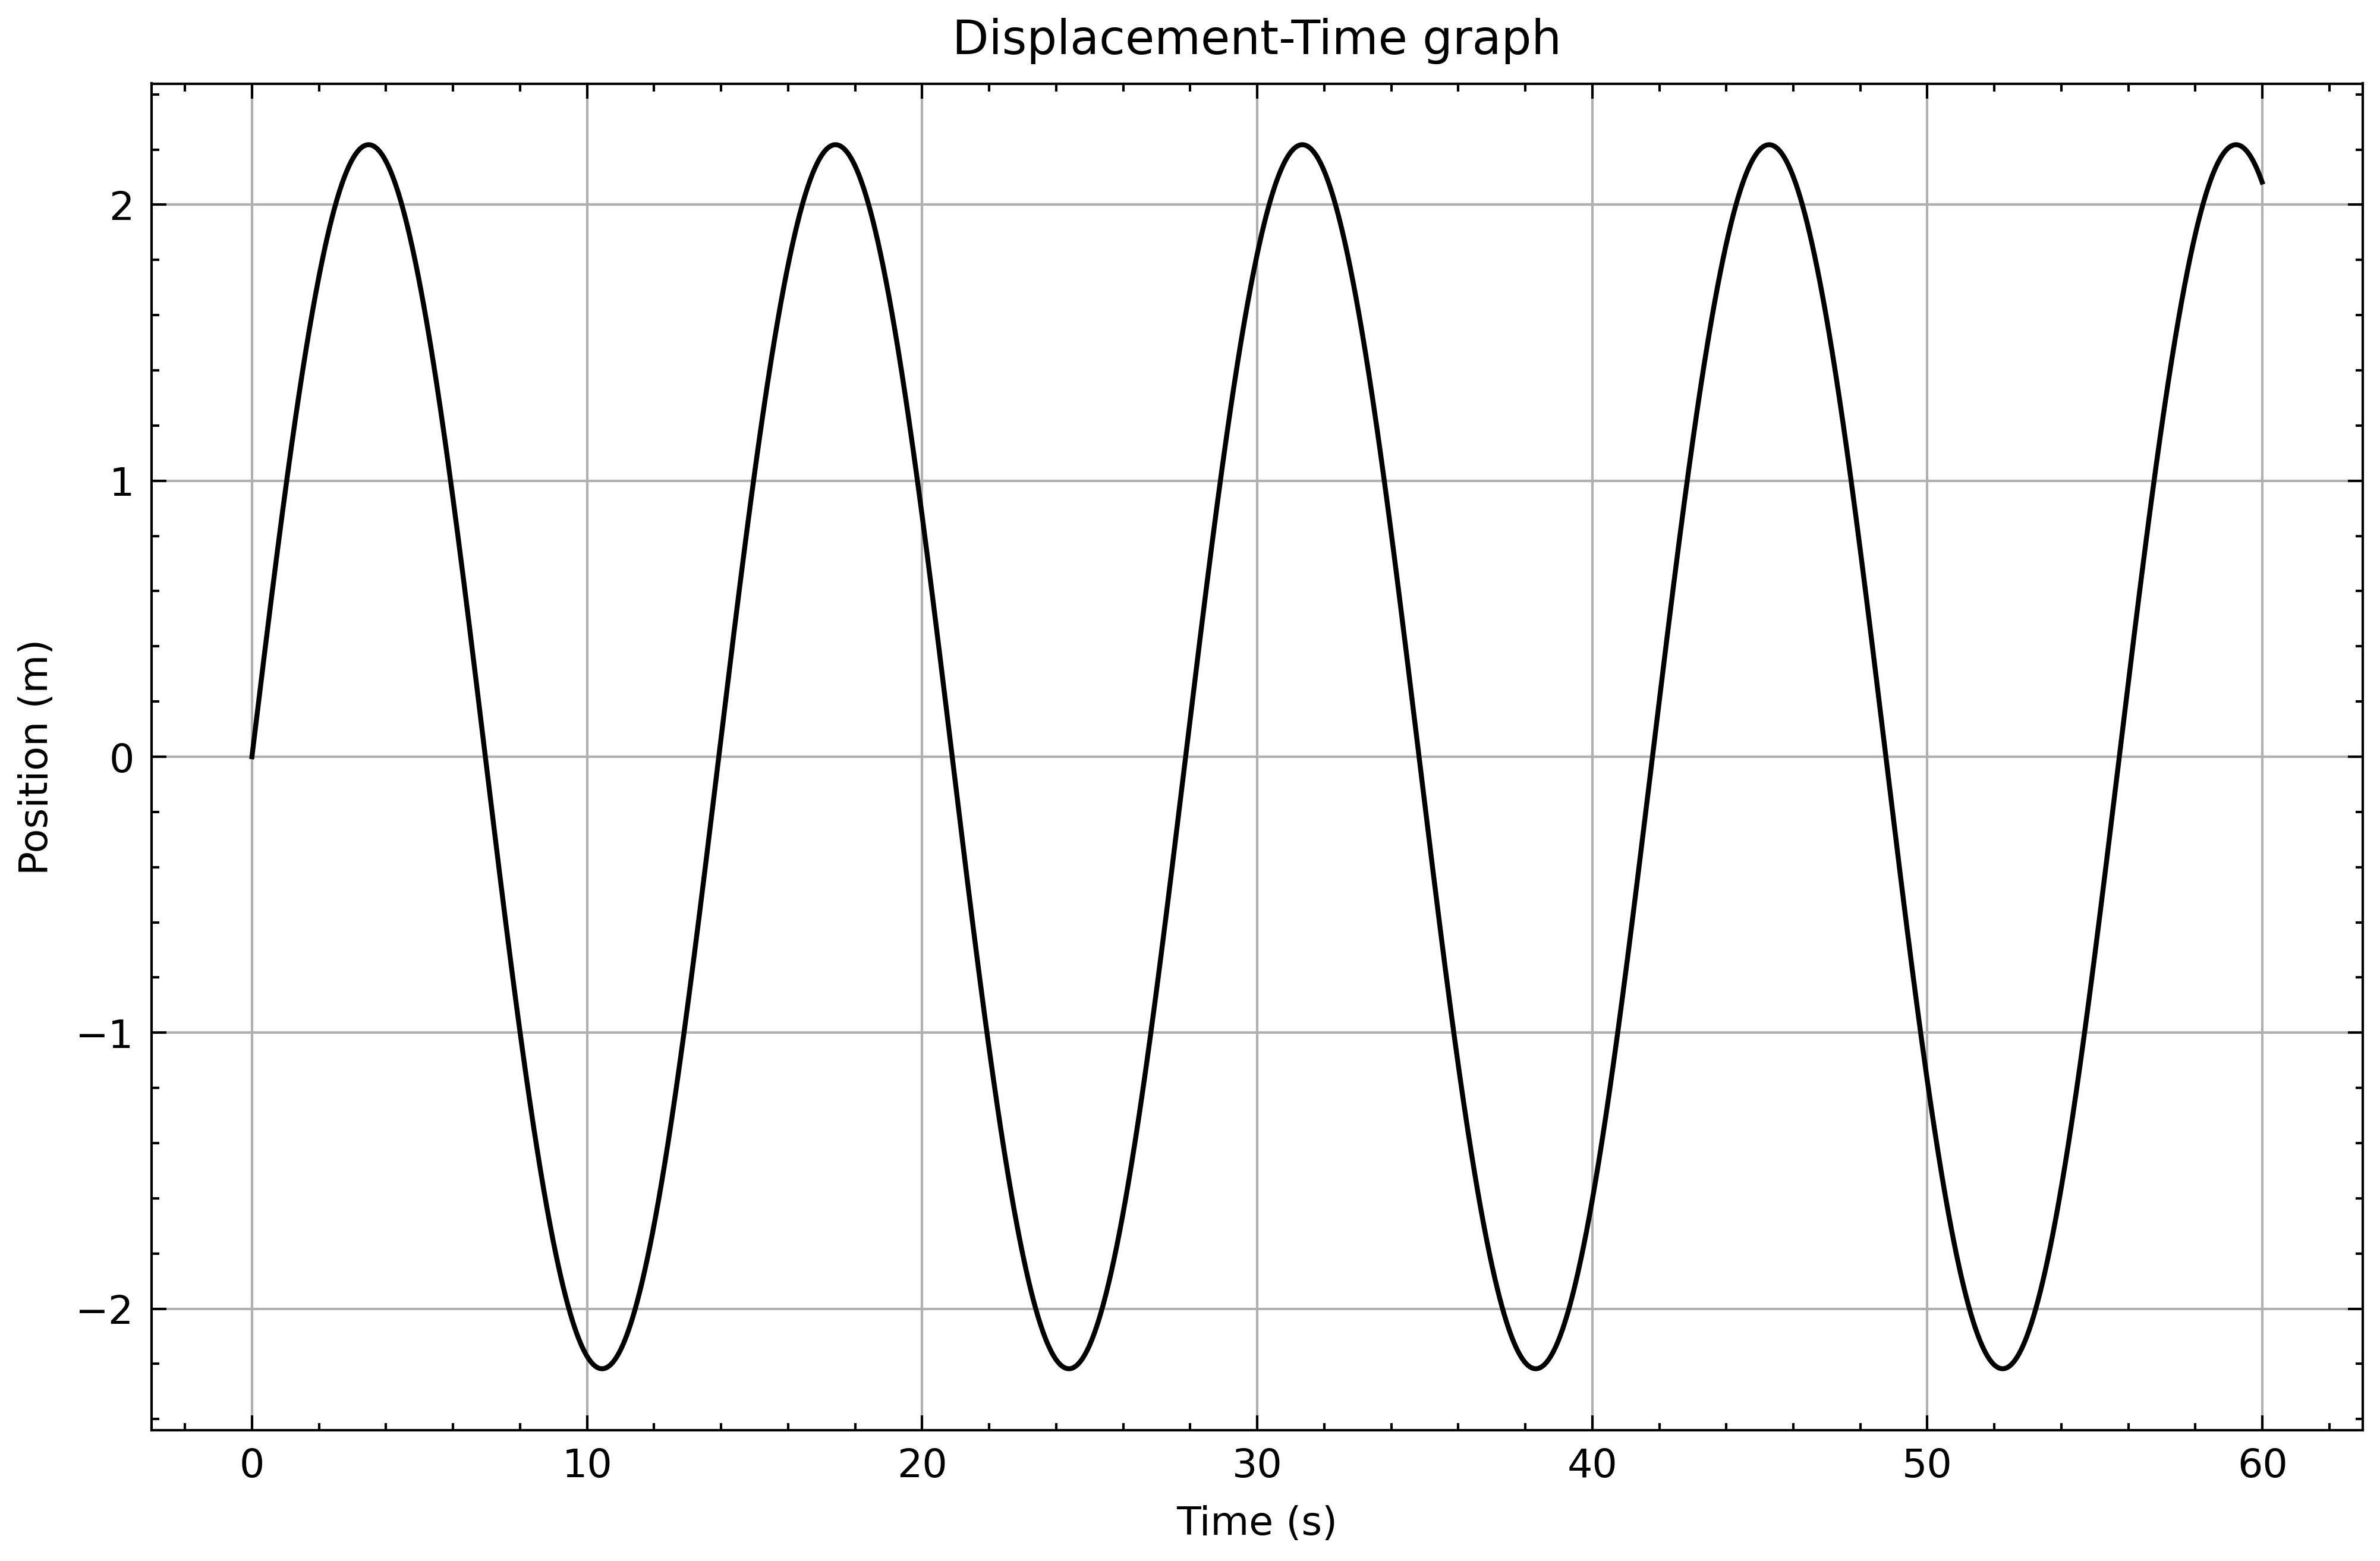

In [448]:
integral_const = smp.solve([function.rhs.subs(t, 0)
               - INITIAL_CONDITIONS["x_0"],
               function.rhs.diff(t).subs(t, 0) - INITIAL_CONDITIONS["v_0"]])

function = function.subs(integral_const)
function = function.subs(k, MASTER_PARAMS["k"])
function = function.subs(m, MASTER_PARAMS["m"])

#b = damping factor
function = function.subs(b, 0)

function_lmd = smp.lambdify(t, function.rhs, "numpy")

time = np.arange(0, 60, 0.01)
print("Analytical solution:")
display(function)

plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Displacement-Time graph")
plt.plot(time, np.real(function_lmd(time)));

In [484]:
TIMESTEP = 0.1
DECIMAL_PLACES = 5 
END_TIME = 500.0
TIME_ARRAY = np.linspace(0, END_TIME, (int(END_TIME/TIMESTEP)+1))
N_STEPS = int(END_TIME/TIMESTEP) +1

def iterator(initial_values:dict = INITIAL_CONDITIONS,
             end_time:float = END_TIME, timestep:float = TIMESTEP,
             dp:float = DECIMAL_PLACES, damping:float = 0,  
             is_verlet:bool = False, is_euler_cromer:bool = False,
             is_improved_euler: bool = False) -> np.ndarray:
    
    """
    Iterator functions that calculates the position and velocity at a given timestep. Calls 
    Default method is the Forward Euler. 
    """
    time = 0
    #Corrected end time is to ensure that the it is a multiple of the timestep
    corrected_end_time = np.around(math.floor( end_time / timestep)* timestep, 
                                  decimals = dp)
    pos, vel = initial_values["x_0"], initial_values["v_0"]
    
    if is_verlet:
        x_minus1, vel_minus1 = pos, vel
        
        #Verlet is not self starting, hence Improved Euler is used to generate
        #datapoint.
        pos, vel = improved_euler(x_minus1, vel_minus1, timestep=timestep,
                                 damping=damping)
        
        position_array = [x_minus1]
        velocity_array = [vel_minus1]
        
        while time < corrected_end_time:
            
            time += timestep
            #The time is rounded to prevent errors whilst using smaller timesteps
            time = round(time, dp)

            x_plus1, vel = verlet(pos, x_minus1, timestep=timestep, 
                                 damping=damping)
            
            position_array.append(pos)
            velocity_array.append(vel)
            
            x_minus1 = pos
            pos = x_plus1
            
        #asarray used so that the array doesnt produce a duplicate on memory
        return np.asarray(position_array), np.asarray(velocity_array)
    else:
        position_array = [pos]
        velocity_array = [vel]
        
        while time < corrected_end_time:
            
            time += timestep
            time = round(time, dp)
            
            if is_euler_cromer:
                pos, vel = euler_cromer(position_array[-1], velocity_array[-1],
                                       damping=damping, timestep=timestep)
                
                position_array.append(pos)
                velocity_array.append(vel)
            
            elif is_improved_euler:
                pos, vel = improved_euler(position_array[-1], velocity_array[-1],
                                       damping=damping, timestep=timestep)
                b
                position_array.append(pos)
                velocity_array.append(vel)

            else:
                pos, vel = forward_euler(position_array[-1], velocity_array[-1],
                                       damping=damping, timestep=timestep)
                position_array.append(pos)
                velocity_array.append(vel)
        return np.asarray(position_array), np.asarray(velocity_array)

In [425]:
azsdasada = INITIAL_CONDITIONS
azsdasada["v_0"]

2

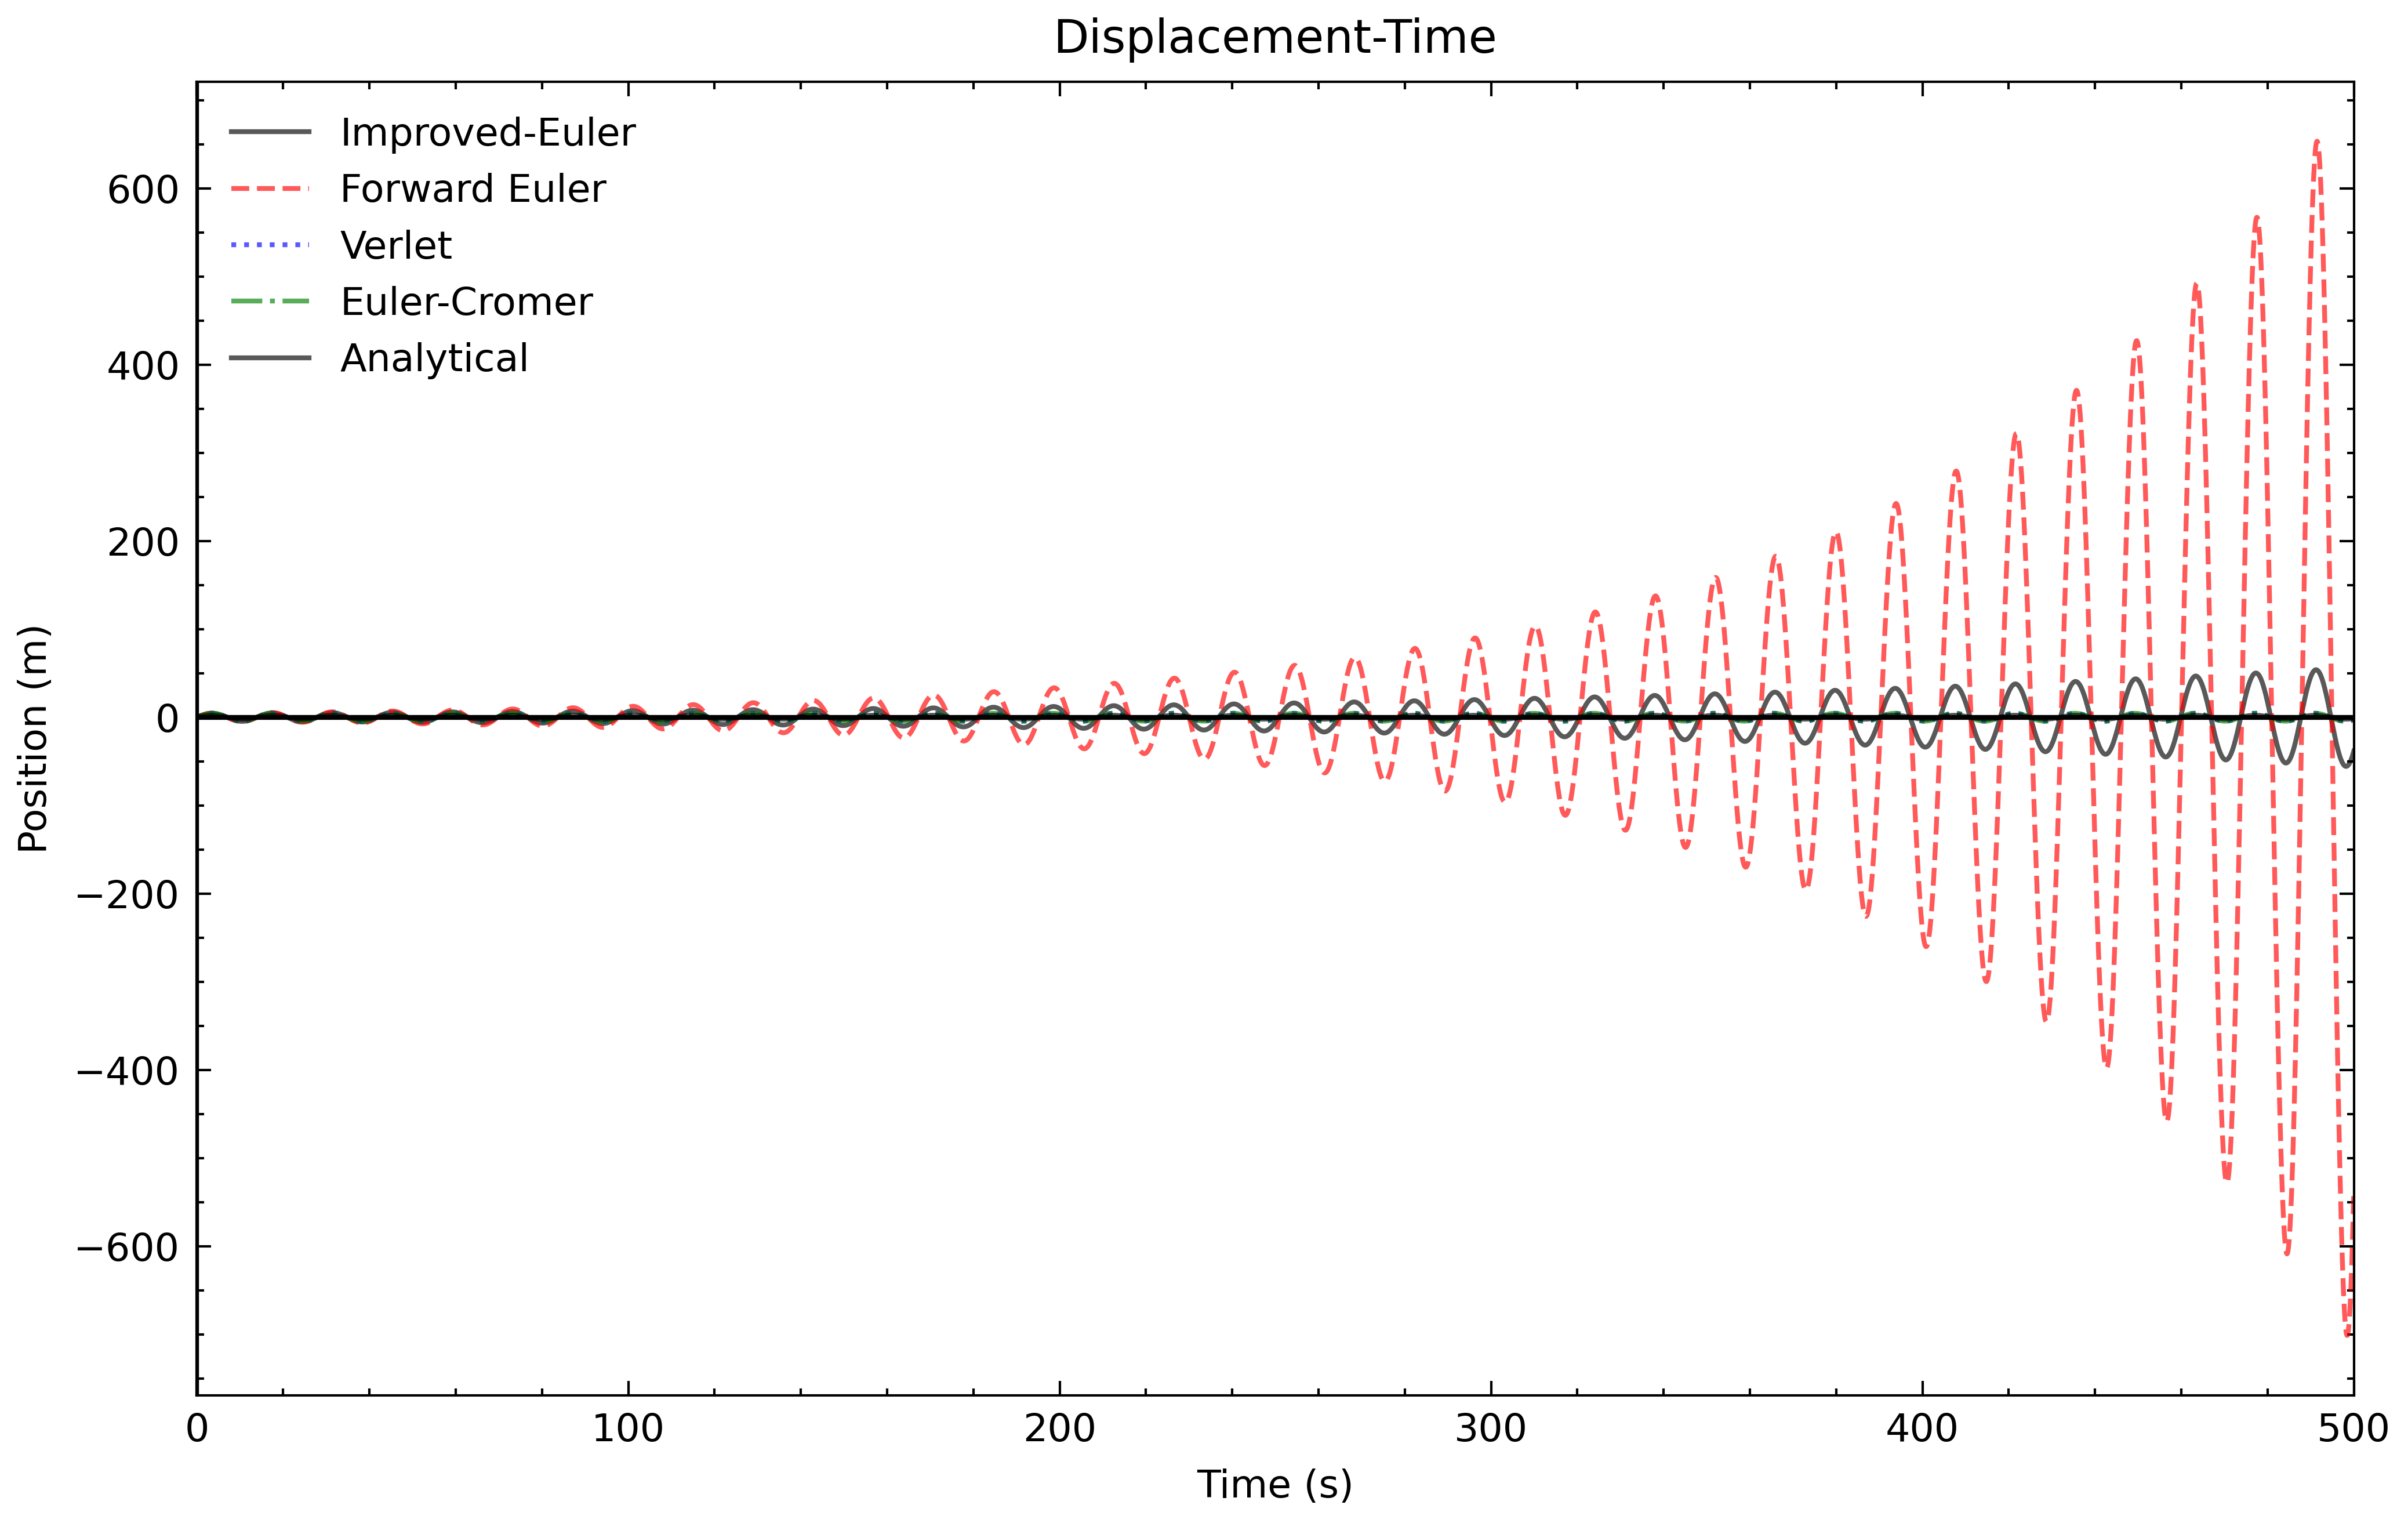

In [500]:

plt.plot(TIME_ARRAY, iterator(is_improved_euler=True)[0], alpha=0.65);
plt.plot(TIME_ARRAY, iterator()[0], alpha=0.65);
plt.plot(TIME_ARRAY, iterator(is_verlet=True)[0], alpha=0.65);
plt.plot(TIME_ARRAY, iterator(is_euler_cromer=True)[0], alpha=0.65);
plt.plot(TIME_ARRAY, analytical_solution(TIME_ARRAY)[0], alpha=0.65);
plt.axvline(0);
plt.axhline(0);
plt.xlim(left=0, right=END_TIME);
plt.legend(["Improved-Euler", "Forward Euler", "Verlet", "Euler-Cromer", "Analytical"]);


plt.xlabel("Time (s)");
plt.ylabel("Position (m)");
plt.title("Displacement-Time");

Although it is not entirely easy to see, some methods, namely Euler and Improved-Euler do not conserve energy as expected.

*Note about errors:*

The biggest source of errors of each point are the local truncation errors associated with each measurement. This is the dominant source of error in each measurement. Errors in each point arising from floating point errors are much smaller than the truncation errors for the time steps concerned and hence are omitted from calculations. 

Error bars would be too small to see in the previous plot and would also are unncessary to show the general trend hence are omitted in the above graph.

Instead of purely relying on visual aids, we define a set of metrics that we want to minimise, defined below.

*Source: https://www.tensorflow.org/api_docs/python/tf/keras/metrics*

In [511]:
#Evaluation Metrics

def mean_squared_error(x_true: np.ndarray, x_pred: np.ndarray) -> float:
    """
    Calculates the mean squared error between two sets of arrays.
    Returns the value
    """
    mse = np.square(np.subtract(x_true, x_pred)).mean(axis=0)
    assert isinstance(mse, float) 
    return mse

def mean_absolute_error(x_true: np.ndarray, x_pred: np.ndarray) -> float:
    """
    Calculates mean absolute error between two arrays.
    """
    mae = np.mean(np.abs(np.subtract(x_true, x_pred)))
    assert isinstance(mae, float)
    
    return mae

def chi_square(prediction, observation, observation_uncertainty):
    """
    Returns the chi squared. Calculated in the usual manner
    """
    return np.sum((observation - prediction)**2 / observation_uncertainty**2)


Comments on  metrics: 

The goal of viewing this metrics is to understand which approximator is closest to the analytical values.  The chi-squared metric is used to check whether the parameters of the candidate model, $\bar{F}$ is a good estimate of the true model $F$.  By finding the intergrating method with the lowest  $\chi^{2}$ we are performing a manual minimisation of the KL divergence. An ideal case would be when $D_{KL}$ = 0 between the candidate and the true model, this consequentially corresponds to a $\chi^{2}_{red}$ of 0.  This would mean no information is lost between the two models.

Although taking this method is good, it might not necessarily be the best metric as we are interested in minimising the errors obtained by each intergrating method.  This does not require a candidate model to be found, minimising the mean absolute error and mean square error would lead to the same global minima as the $\chi^{2}_{red}$.  It is important to note that the MSE and the MAE do not have the same local minima with MSE penalising larger diffrences more than smaller. MAE does not suffer from this problem. 

In [428]:
ITERATORS = ["Euler", "Improved Euler", "Verlet", "Euler-Cromer"]
METRICS = ["MSE", "MAE"]
checkers = ["", "is_improved_euler", "is_verlet",
            "is_euler_cromer"]
first_metric_array = []

for items in range(len(ITERATORS)):
    if items == 0:
        first_metric_array.append(
        [mean_squared_error(analytical_solution(TIME_ARRAY)[0], iterator()[0]),
         mean_absolute_error(analytical_solution(TIME_ARRAY)[0], iterator()[0])
         ])

    else:
        temp_checker = {f"{checkers[items]}":True}
        first_metric_array.append(
        [mean_squared_error(analytical_solution(TIME_ARRAY)[0], iterator(**temp_checker)[0]),
         mean_absolute_error(analytical_solution(TIME_ARRAY)[0], iterator(**temp_checker)[0])
         ])


first_metric_dataframe = pd.DataFrame({"Methods":ITERATORS, 
                                     (f"{METRICS[0]}"): np.array(first_metric_array)[:, 0],
                                     (f"{METRICS[1]}"): np.array(first_metric_array)[:,1]})

del temp_checker
del items

first_metric_dataframe

Methods         MSE        MAE
0           Euler  270.614470  11.637274
1  Improved Euler   28.104415   4.297552
2          Verlet    2.464205   1.413802
3    Euler-Cromer    2.464205   1.413802

It is evident that Euler-Cromer and Verlet methods are the superior methods of doing this task, hence they will have to be investigated further. So lets zoom into the graph created above and see what is happening. Introducing a slight damping force to allow for clearer conclusion to be drawn.

In [441]:
def residual_plot(y_pred:np.ndarray, y_true: np.ndarray,
                  clr, x_axis: np.ndarray):
    """
    Plots the residuals for data.
    """
    plt.grid()
    plt.axhline(0)
    return plt.plot(x_axis, (y_pred-y_true),
     alpha=0.5, color = clr)

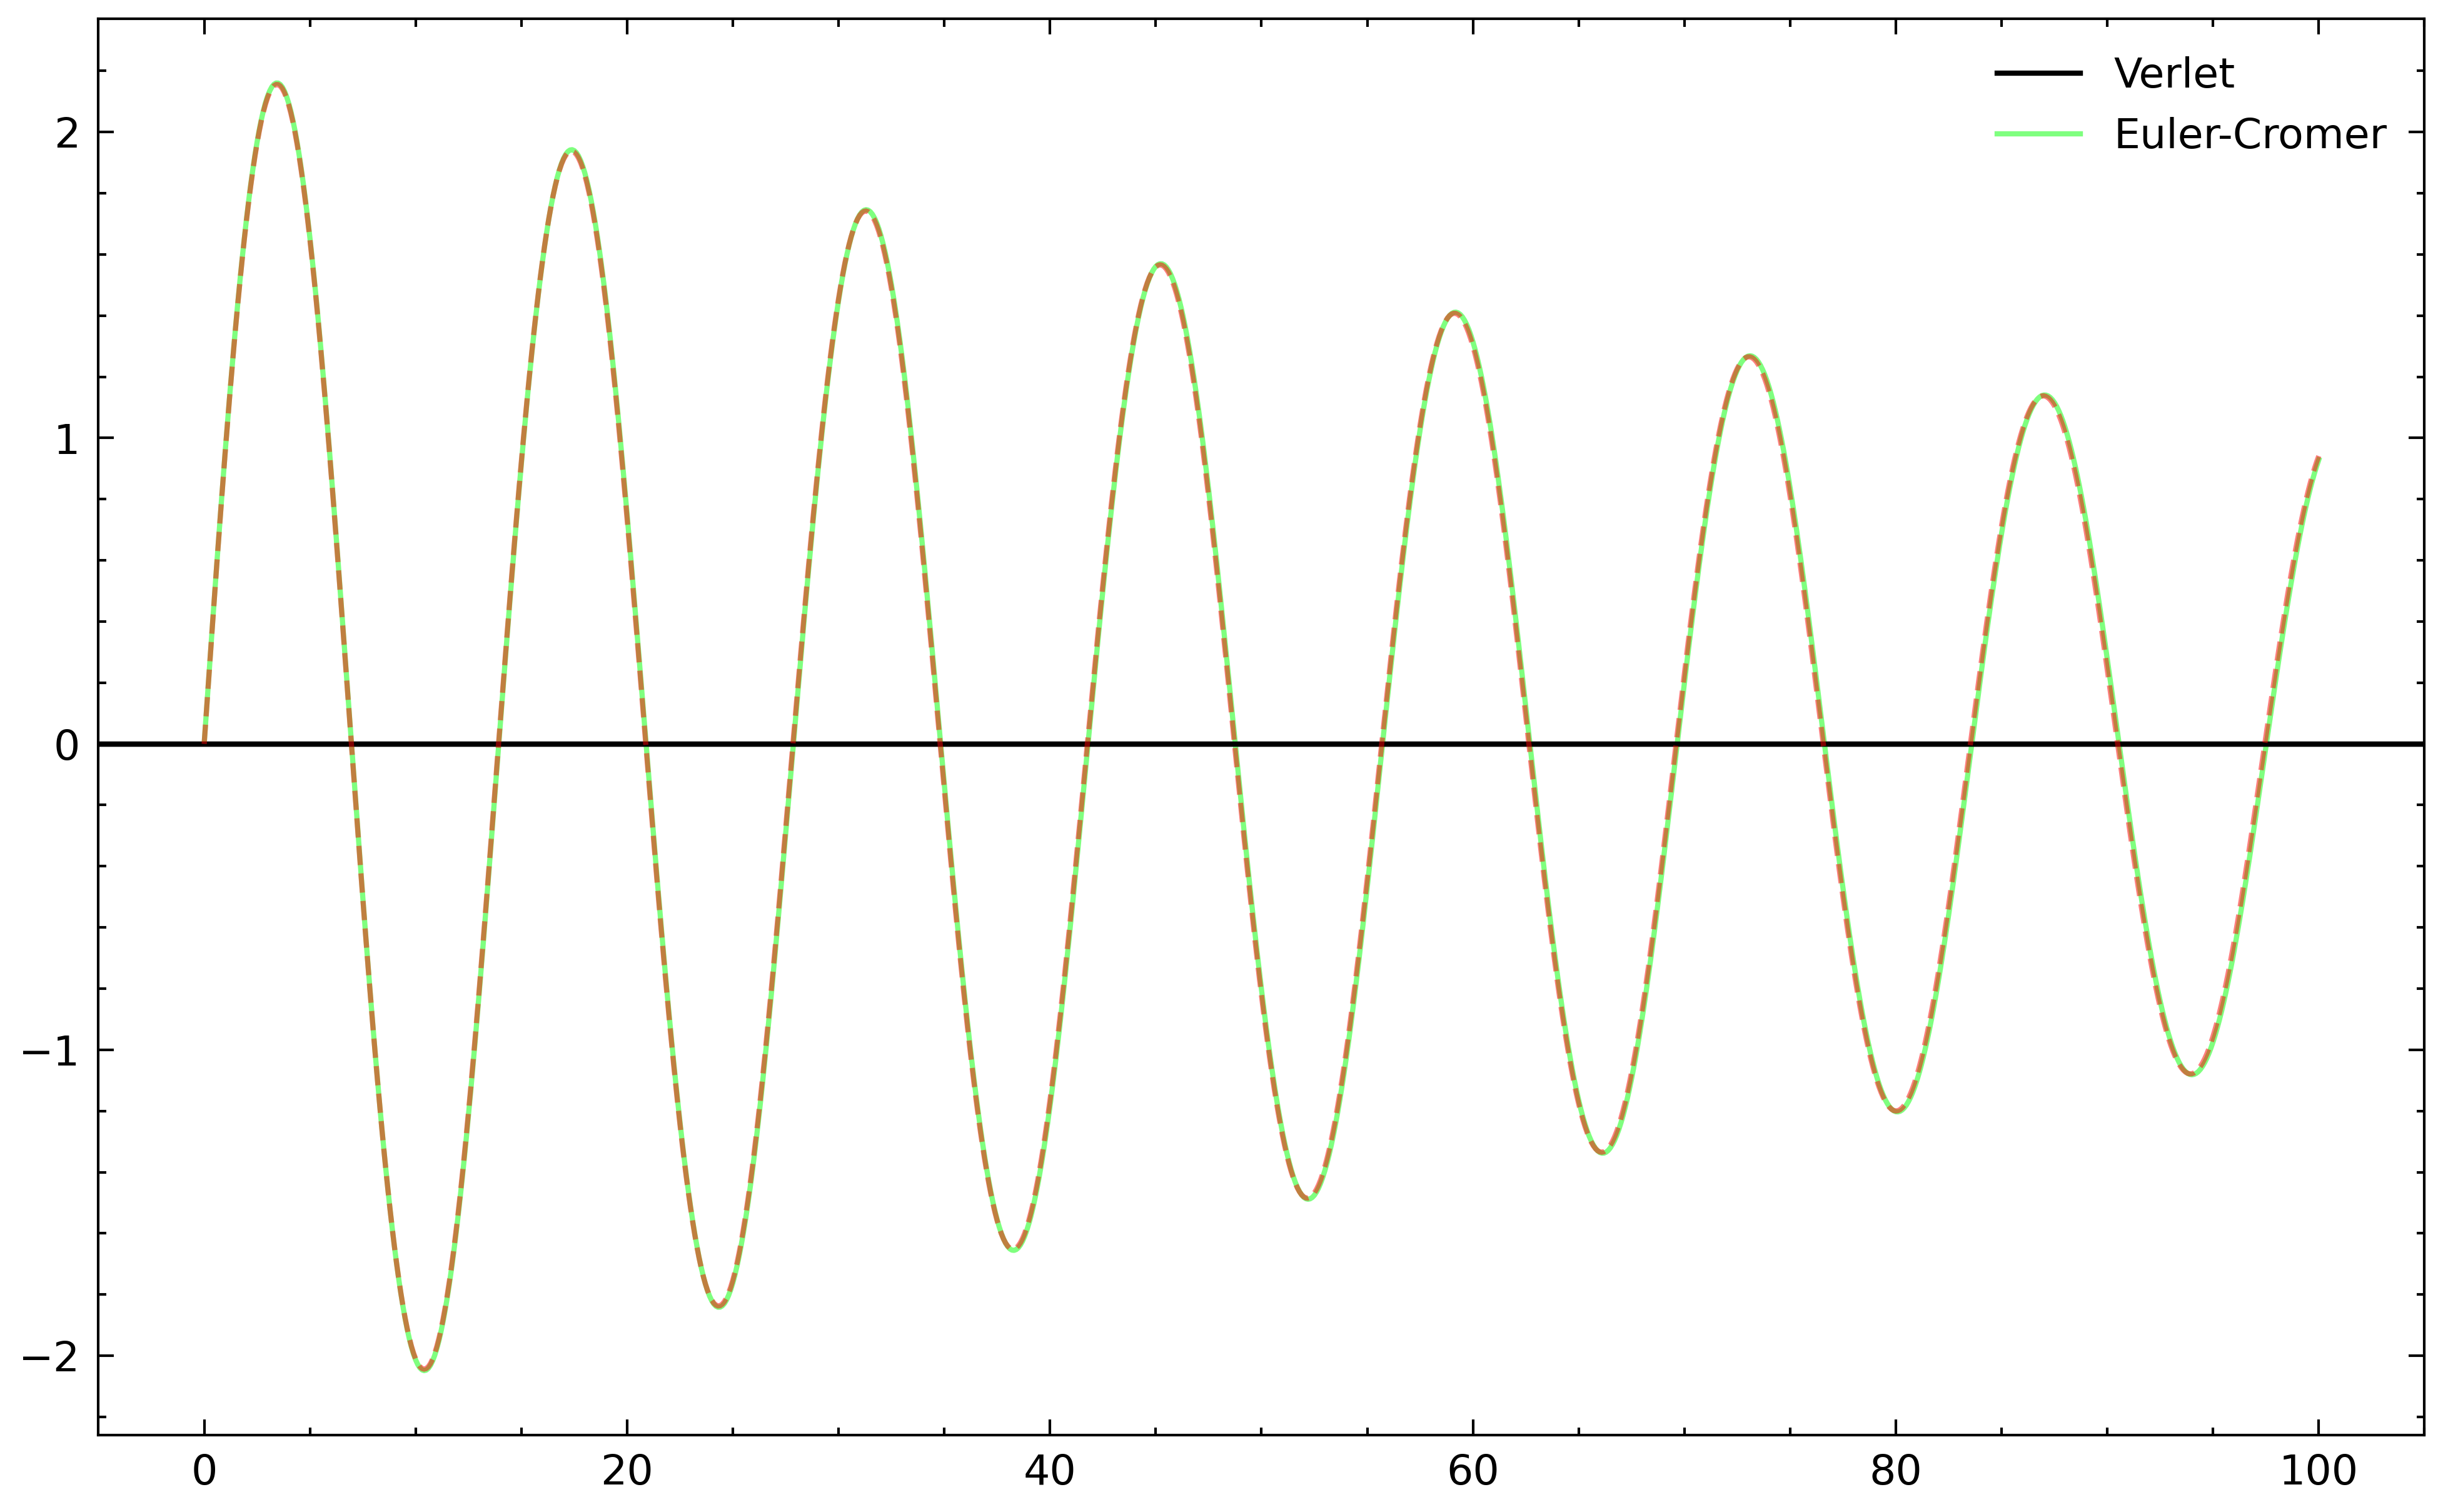

In [501]:

residual_plot(iterator(is_verlet=True, end_time=100.0, damping=math.sqrt(OMEGA_SQR)/10)[0],
              analytical_solution(TIME_ARRAY[:1001], damping=math.sqrt(OMEGA_SQR)/10)[0],  "lime",
             TIME_ARRAY[:1001])
residual_plot(iterator(is_euler_cromer=True, end_time=100.0, damping=math.sqrt(OMEGA_SQR)/10)[0],
              analytical_solution(TIME_ARRAY[:1001], damping=math.sqrt(OMEGA_SQR)/10)[0],  "red",
             TIME_ARRAY[:1001])

plt.rcParams["legend.loc"] = ('best')
plt.legend(["Verlet", "Euler-Cromer"]);

From the residuals its evident that different considerations is needed to discern between the two methods.

## Energy Considerations 

Now we consider the energy to check if energy is conserved. For simplification, we set the damping back to zero. For further simplicity, we set the value of b and m = 1

(5.75, 6.1)

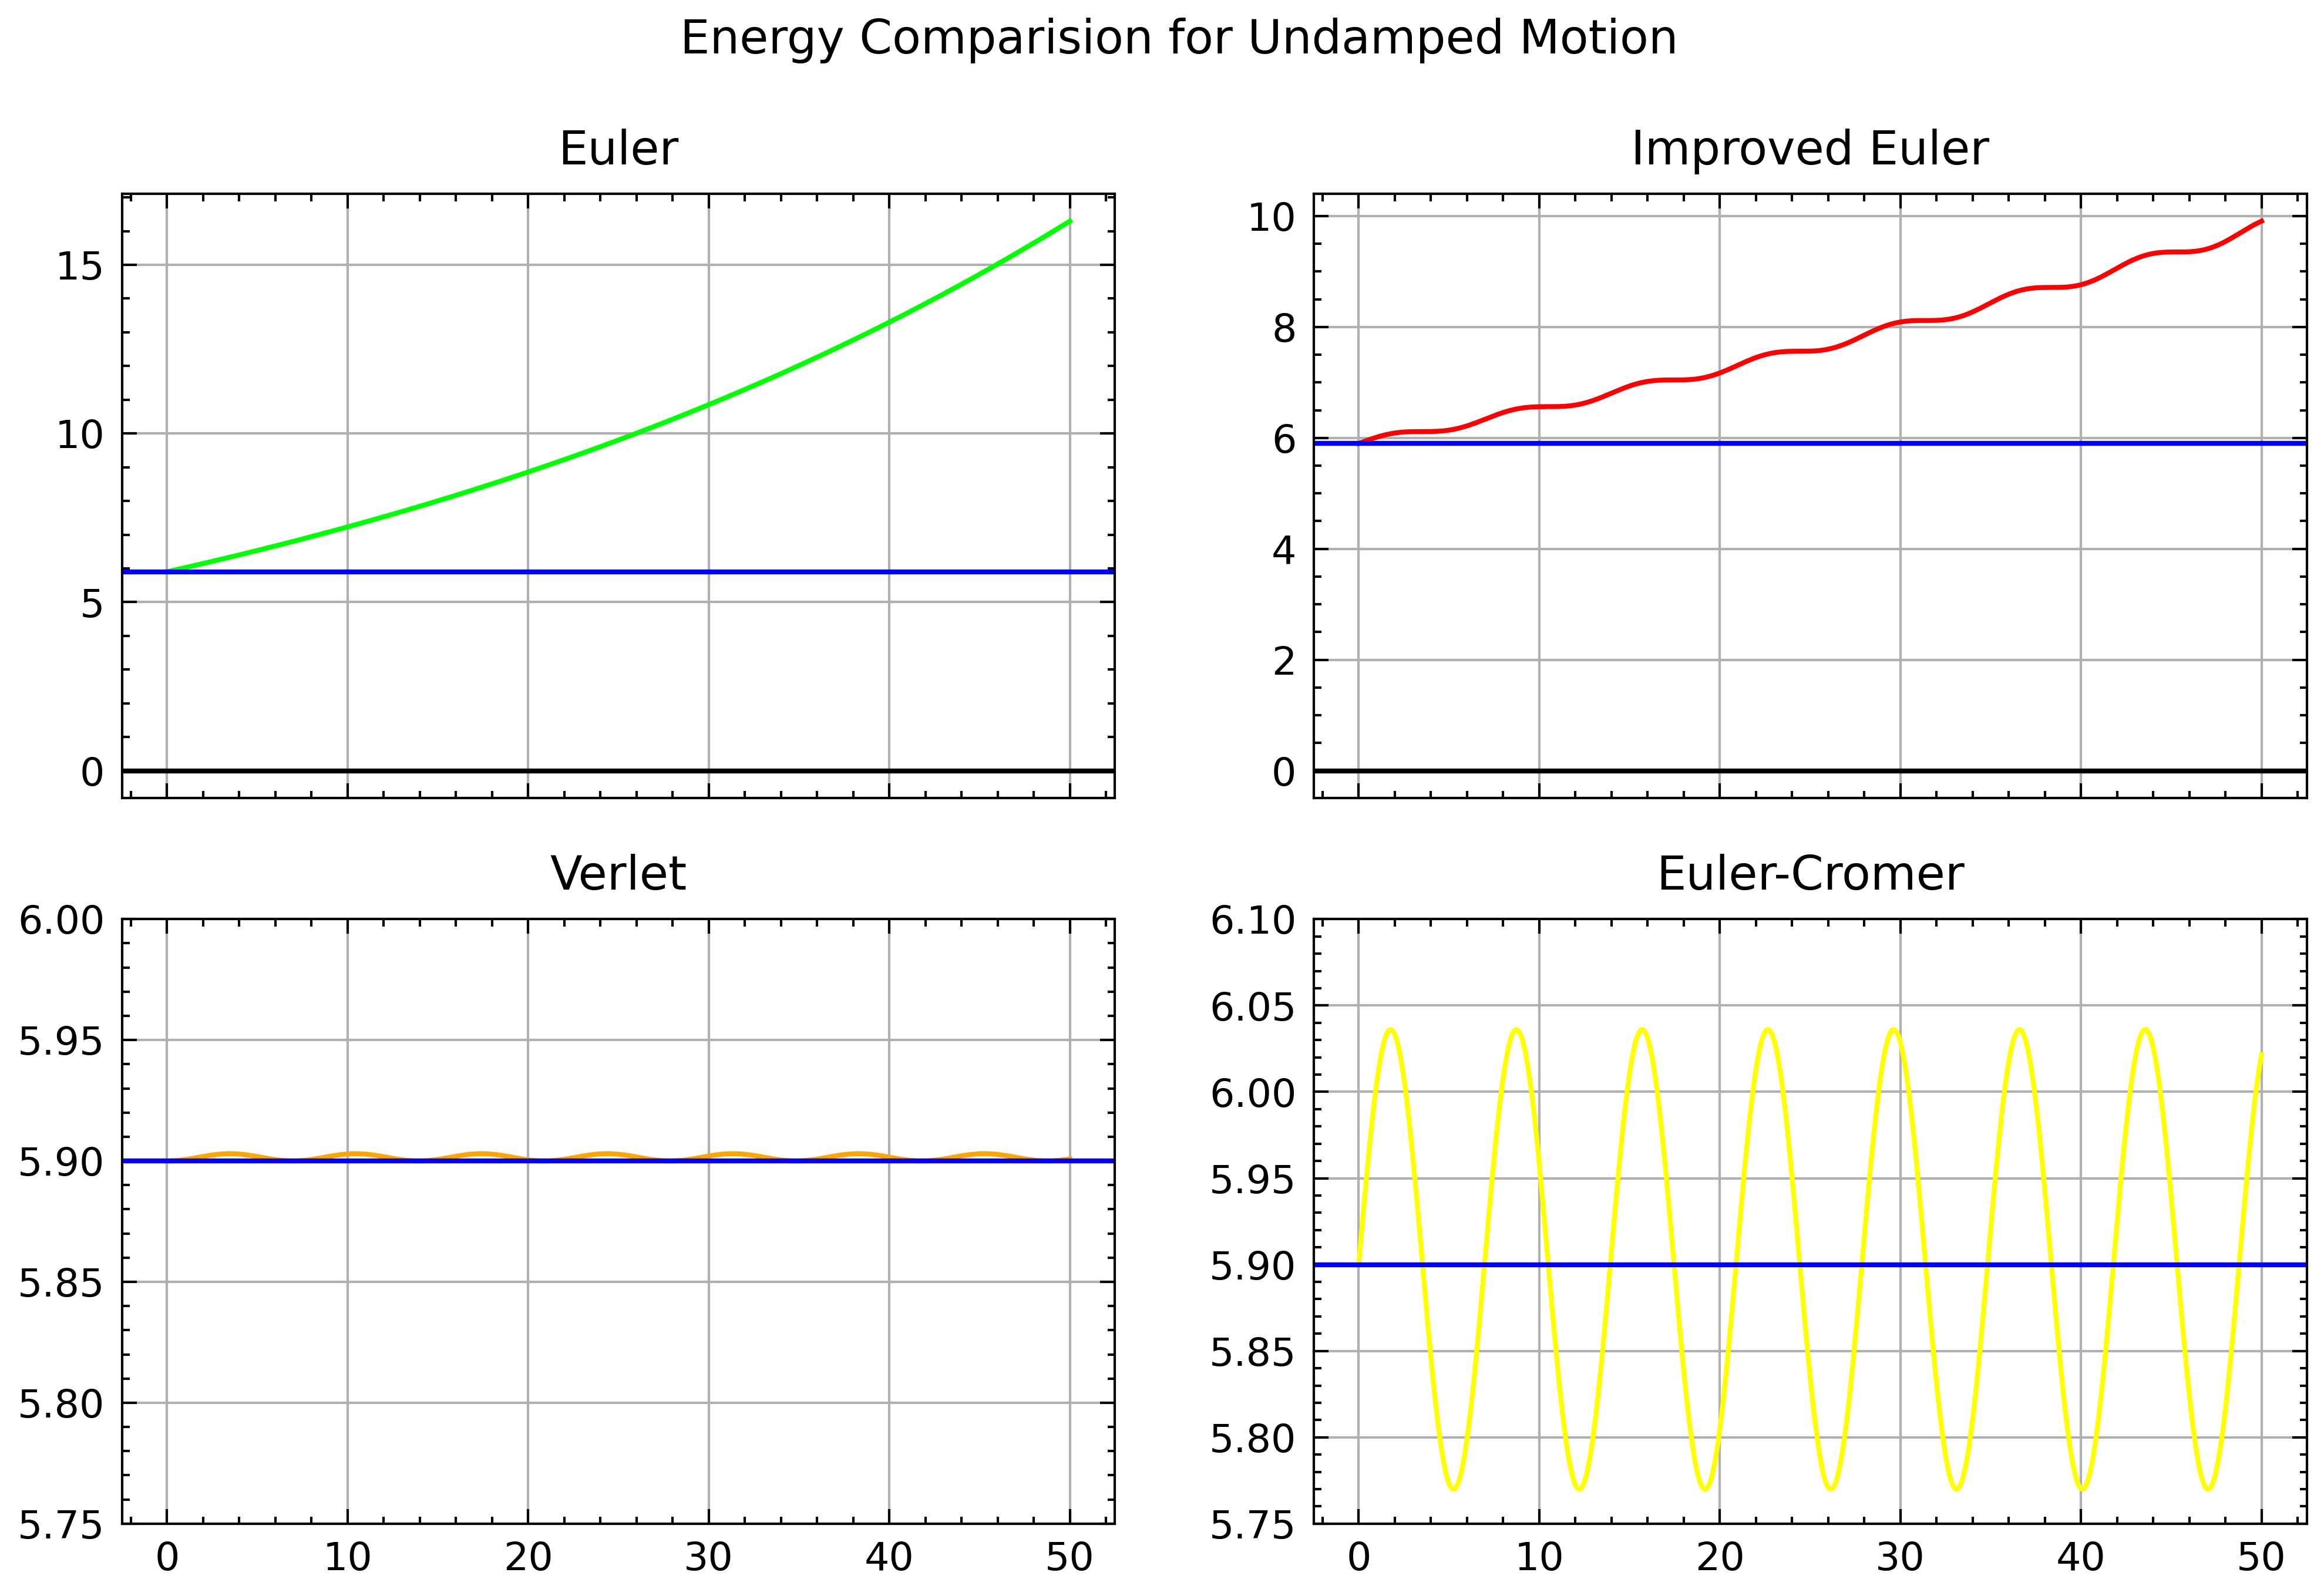

In [510]:

initial_energry = 0.5*MASTER_PARAMS["m"]*INITIAL_CONDITIONS["v_0"]**2 + 0.5*MASTER_PARAMS["k"]*INITIAL_CONDITIONS["x_0"]**2

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.suptitle("Energy Comparision for Undamped Motion")

ax[0, 0].axhline(0)
ax[0, 0].grid()
ax[0, 0].set_title("Euler")
ax[0, 0].plot(TIME_ARRAY[:501], energy_calculator(iterator(end_time=50.0)[0],
                                                  iterator(end_time=50.0)[1]),  color="lime");
ax[0, 0].axhline(initial_energry, color="blue")

ax[0, 1].axhline(0)
ax[0, 1].grid()
ax[0, 1].set_title("Improved Euler")
ax[0, 1].plot(TIME_ARRAY[:501], energy_calculator(iterator(is_improved_euler=True, end_time=50.0)[0],
                                                    iterator(is_improved_euler=True, end_time=50.0)[1]), color="red")
ax[0, 1].axhline(initial_energry, color="blue")

ax[1, 0].axhline(0)
ax[1, 0].grid()
ax[1, 0].set_title("Verlet")
ax[1, 0].plot(TIME_ARRAY[:501], energy_calculator(iterator(is_verlet=True, end_time=50.0)[0],
                                                    iterator(is_verlet=True, end_time=50.0)[1]), color="orange")
ax[1, 0].axhline(initial_energry, color="blue")
ax[1, 0].set_ylim(5.75, 6)

ax[1, 1].axhline(0)
ax[1, 1].grid()
ax[1, 1].set_title("Euler-Cromer")
ax[1, 1].plot(TIME_ARRAY[:501], energy_calculator(iterator(is_euler_cromer=True, end_time=50.0)[0],
                                                    iterator(is_euler_cromer=True, end_time=50.0)[1]), color="yellow");
ax[1, 1].axhline(initial_energry, color="blue")
ax[1, 1].set_ylim(5.75, 6.1)

It is evident from these plots that Verlet is the more accurate, symplectic method.

## Effect of step-size

We check the Mean-Absolute Error between the theoretical and the calculated energies using each method for different step-sizes.

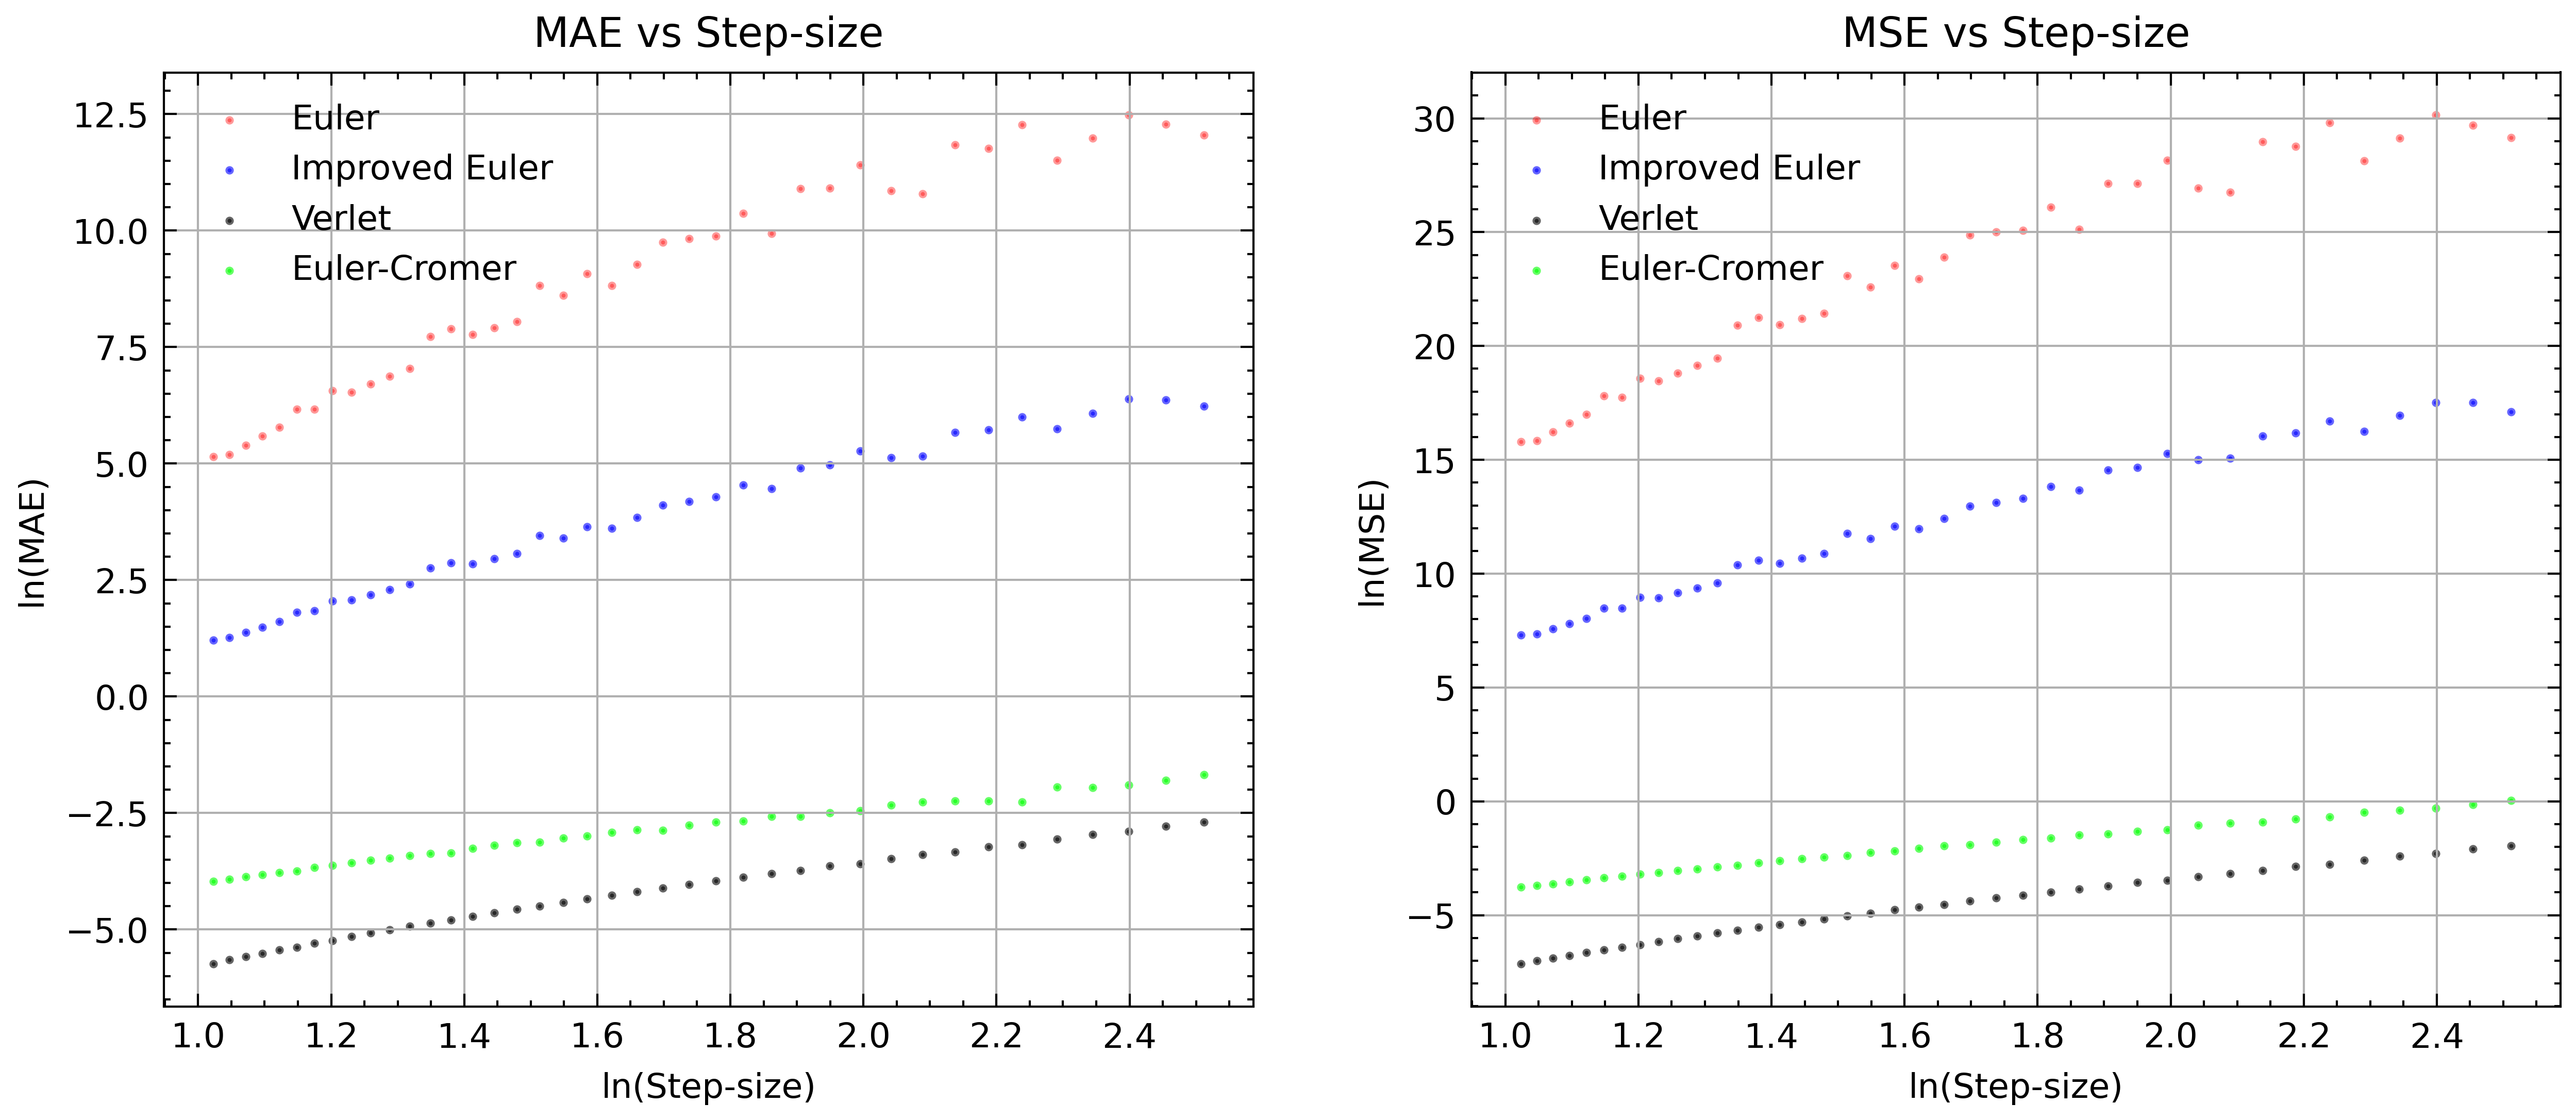

In [566]:
step_size_values = np.logspace(0.01, 0.4, 40)
fig, ax = plt.subplots(ncols=2, sharex=True)
plt.rcParams["figure.figsize"] = (10,4)

colours = ["red", "blue", "black", "lime", "orange"]
step_mae_array = []
step_mse_array = []

for items in range(len(ITERATORS)):
    
    if items==0:
        
        for i in range(len(step_size_values)):

            energy_iterator = energy_calculator(iterator(end_time=50.0,
                                                        timestep=step_size_values[i])[0],
                                                iterator(end_time=50.0,
                                                        timestep=step_size_values[i])[1])

            step_mse_array.append((mean_squared_error([initial_energry]*len(energy_iterator),
                                                      energy_iterator))/len(energy_iterator))
            step_mae_array.append((mean_absolute_error([initial_energry]*len(energy_iterator),
                                                       energy_iterator))/len(energy_iterator))
            
            if i == len(step_size_values)-1:
                
                ax[0].scatter(step_size_values, np.log(step_mae_array),
                              alpha=0.4, s=0.9, color=f"{colours[items]}")
                ax[1].scatter(step_size_values, np.log(step_mse_array),
                              alpha=0.4, s=0.9, color=f"{colours[items]}")
                del i
                
    else:
        for i in range(len(step_size_values)):
            
            if i == 0:
                step_mae_array = []
                step_mse_array = []
            temp_checker = {f"{checkers[items]}":True}
            energy_iterator = energy_calculator(iterator(**temp_checker,
                                                         end_time=50.0,
                                                        timestep=step_size_values[i],
                                                        )[0],
                                                iterator(**temp_checker,
                                                         end_time=50.0,
                                                        timestep=step_size_values[i])[1])

            step_mse_array.append((mean_squared_error([initial_energry]*len(energy_iterator),
                                                      energy_iterator))/len(energy_iterator))
            step_mae_array.append((mean_absolute_error([initial_energry]*len(energy_iterator),
                                                       energy_iterator))/len(energy_iterator))
            
            if i == len(step_size_values)-1:
                
                ax[0].scatter(step_size_values, np.log(step_mae_array),
                              alpha=0.6, s=0.9, color=colours[items])
                ax[1].scatter(step_size_values, np.log(step_mse_array),
                              alpha=0.6, s=0.9, color=colours[items])
                del i
ax[0].grid()
ax[0].set_xlabel("ln(Step-size)")
ax[0].set_ylabel("ln(MAE)")
ax[0].legend(ITERATORS)
ax[0].set_title("MAE vs Step-size")

ax[1].grid()
ax[1].set_xlabel("ln(Step-size)")
ax[1].set_ylabel("ln(MSE)")
ax[1].legend(ITERATORS)
ax[1].set_title("MSE vs Step-size");

It is evident that Verlet has the lowest MAE and MSE, this is accurate with the theory. This also shows that the global error 
is also the lowest with the Verlet method. Consistent with theory a lower step size yields a better accuracy.  Verlet is a second order method and the error should be linear in $h^2$ but at this given range it yields the best result.

# Verlet

Continuing onwards with the best method, Verlet. The main cases of damping are investigated. 

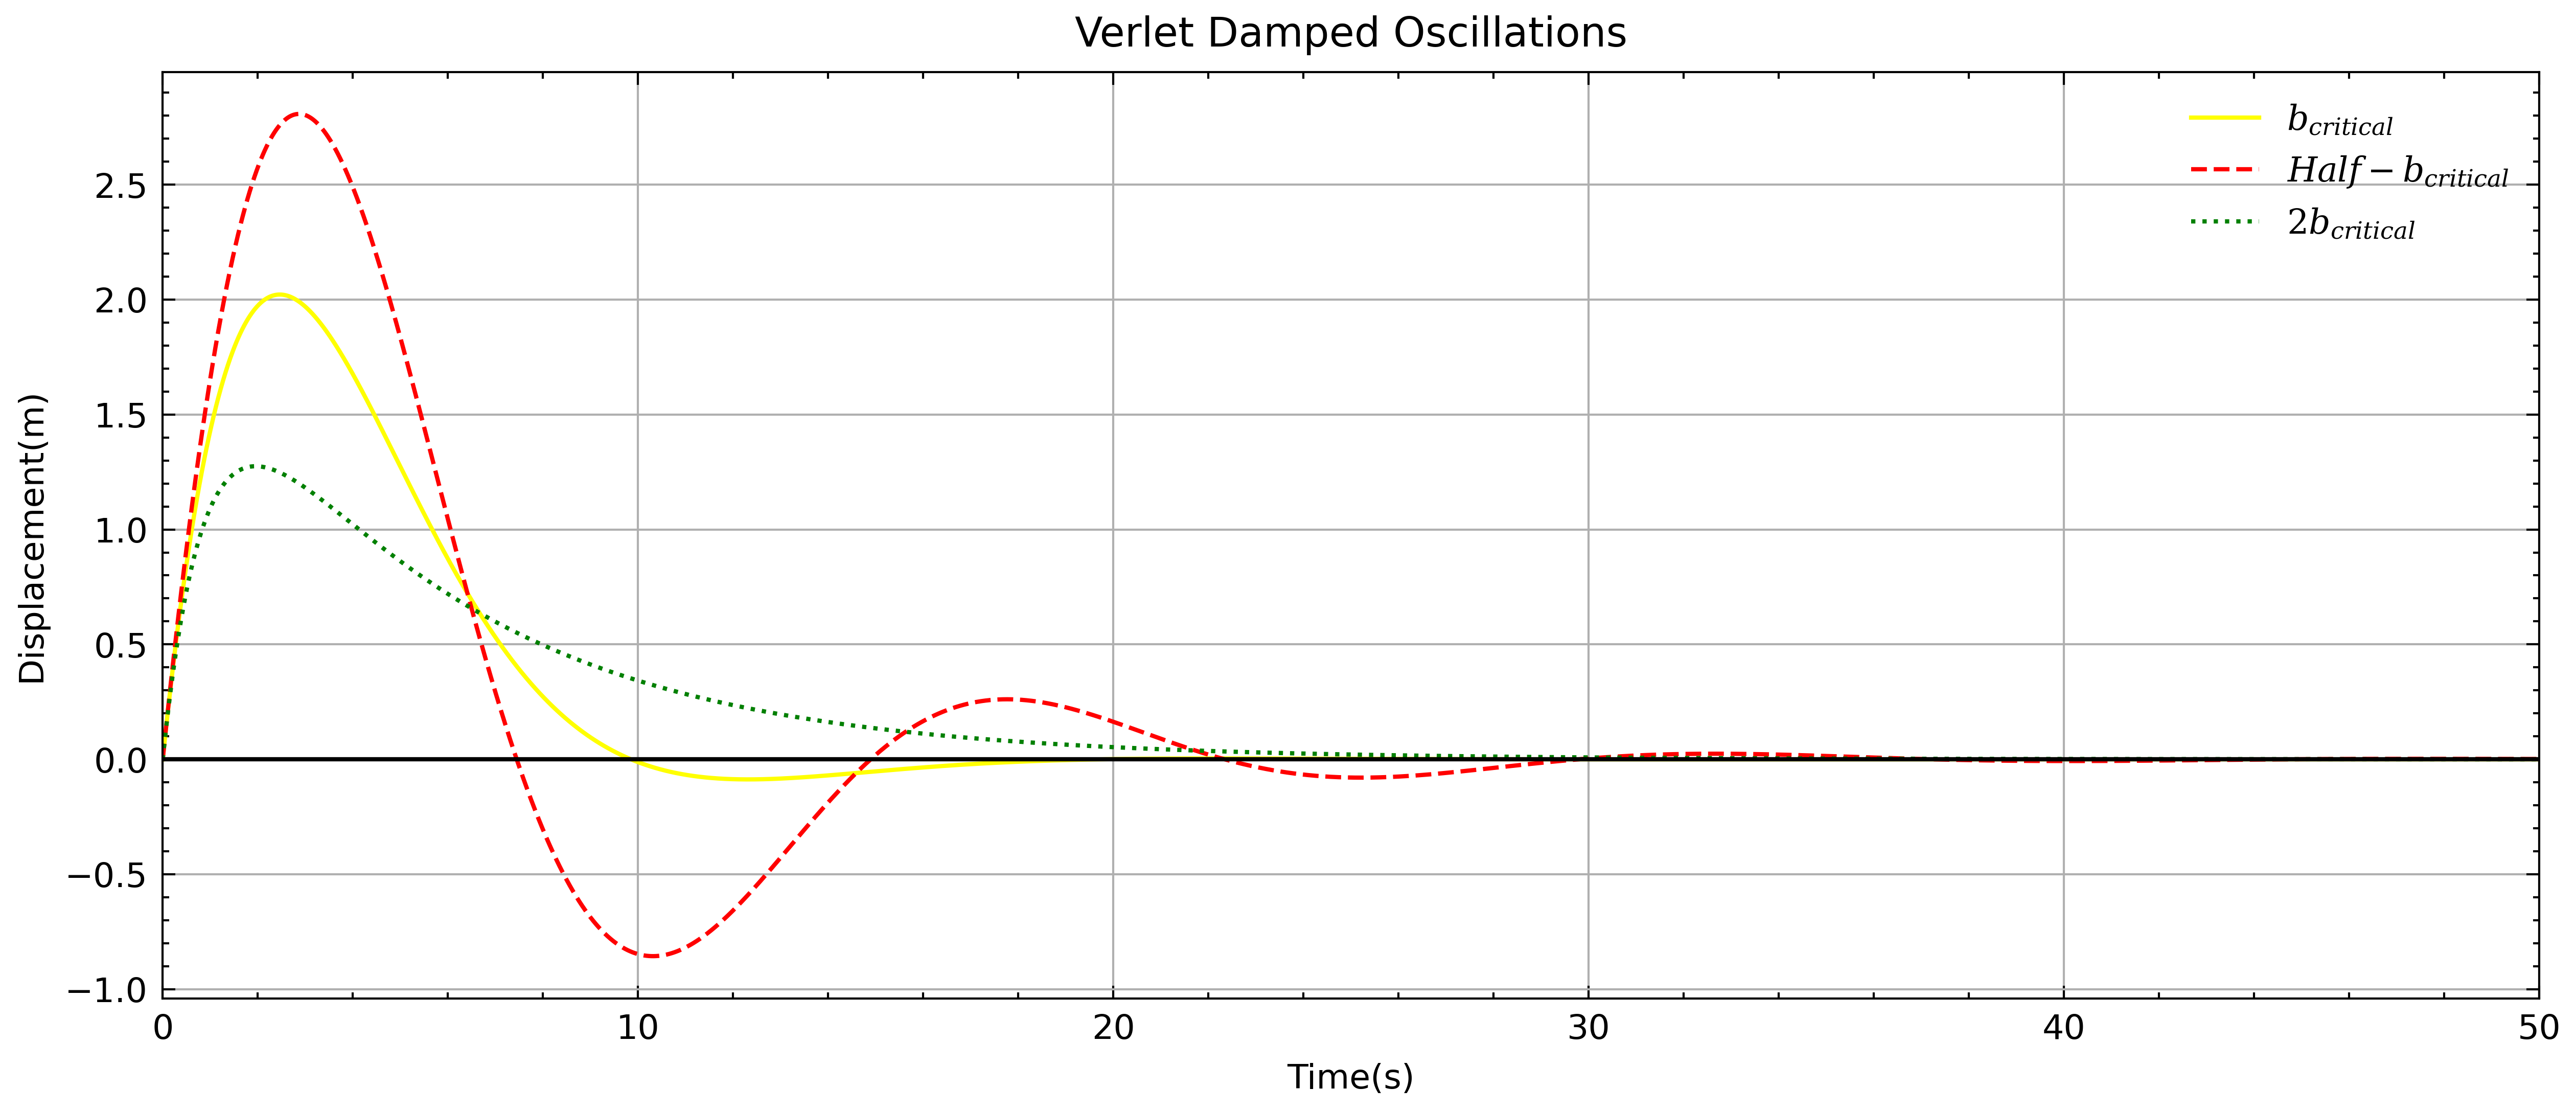

In [595]:
critical_b = np.sqrt(2* MASTER_PARAMS["m"]* MASTER_PARAMS["k"])
dampings = [critical_b, critical_b/2, critical_b*2]
damping_colours = ["yellow", "red", "green"]

plt.rcParams["figure.figsize"] = (10,4)
damping_labels = ["$b_{critical}$", "$Half-b_{critical}$", "$2b_{critical}$"]

for i in range(3):
    plt.plot(TIME_ARRAY[:5001]*TIMESTEP, iterator(is_verlet=True, end_time=50.0, timestep=0.01, damping=dampings[i])[0],
    color=damping_colours[i], label=damping_labels[i])


plt.xlim(left=0, right=50.0)
plt.grid()
plt.axhline(0)
plt.legend(damping_labels)
plt.ylabel("Displacement(m)")
plt.xlabel("Time(s)")
plt.title("Verlet Damped Oscillations");

As can be seen above, the system reaches the point of equillibirum the fastest at the critical value compared to the other damping factors. This is to be expected. When the damping factor is  $\frac{b_{crit}}{2}$ then the oscillations persists, however due to the damping effect, the overall amplitude of the system decreases as expected.  For the case of damping factor of $2b_{crit}$, the system stops oscillating but takes longer to reach the position of equillibrium compared to damping of $b_{crit}$.

Interstingly, at the critical damping value, there is a slight overshoot in the displacment from the position of equillibrium due to the choice of the time-step used, a smaller time-step should yield a smaller overshoot.

Eq(x(t), C1*exp(t*(b - sqrt(b**2 - 4*k*m))/(2*m)) + C2*exp(t*(b + sqrt(b**2 - 4*k*m))/(2*m)))

Eq(x(t), 0.5*(-b + 2.0*sqrt(0.25*b**2 - k*m))*exp(t*(b + sqrt(b**2 - 4*k*m))/(2*m))/sqrt(0.25*b**2 - k*m) + 0.5*(b + 2.0*sqrt(0.25*b**2 - k*m))*exp(t*(b - sqrt(b**2 - 4*k*m))/(2*m))/sqrt(0.25*b**2 - k*m))

Eq(x(t), 0.375823014001414*(-b + 2.66082693913001*sqrt(0.141242937853107*b**2 - 1))*exp(0.169491525423729*t*(b + 2.66082693913001*sqrt(0.141242937853107*b**2 - 1)))/sqrt(0.141242937853107*b**2 - 1) + 0.375823014001414*(b + 2.66082693913001*sqrt(0.141242937853107*b**2 - 1))*exp(0.169491525423729*t*(b - 2.66082693913001*sqrt(0.141242937853107*b**2 - 1)))/sqrt(0.141242937853107*b**2 - 1))

Eq(x(t), 1.0*exp(0.450987616801697*I*t) + 1.0*exp(-0.450987616801697*I*t))

2.6608269391300143
time period 2.8322022335146593


Eq(x(t), 1.0*exp(0.450987616801697*I*t) + 1.0*exp(-0.450987616801697*I*t))

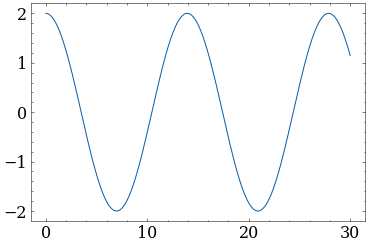

In [44]:
#Practice
from sympy.physics.units.quantities import Quantity
from sympy import Function
from sympy.abc import t
m = Quantity("m")
k  = Quantity("k")
b = Quantity("b")

x = smp.symbols("x", cls=smp.Function)
function = smp.dsolve(m*x(t).diff(t, t) - b*x(t).diff(t)+ k*x(t), x(t))
display(function)


C = smp.solve([function.rhs.subs(t, 0) - 2.0,function.rhs.diff(t).subs(t, 0) -0.0])
function = function.subs(C)
display(function)
function = function.subs(k, MASTER_PARAMS["k"])
function = function.subs(m, MASTER_PARAMS["m"])
display(function)
function = function.subs(b, 0)
display(function)
print((4*2.95*0.6)**0.5)
print("time period", 2*3.14*(np.sqrt(0.6/2.95)))
display(function)
function_lmd = smp.lambdify(t, function.rhs, "numpy")

time = np.arange(0, 30, 0.01)

plt.plot(time, np.real(function_lmd(time)));